# How to use CLASP 
***

## Overview: 
This tutorial demonstrates how to use CLASP with randomly generated data for the identification of spatial, magnitude, and temporal clusters. 

This tutorial includes the necessary packages and functions to run CLASP. Format is as such to allow for continued development.

## Example: 
Example data set: https://github.com/tabitha-lee/CLASP/blob/main/O.txt

Example source points: https://github.com/tabitha-lee/CLASP/blob/main/Dummy_Source_Points.txt

Example data location must be set in "Source Point Information" and "Example Data"

## Required Packages: 

In [1]:
#Libraries Used for CLASP
import numpy as np
import pandas as pd
import glob
import os 
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
#Need to set Environment for the use of basemap - Dependent on user environment
os.environ['PROJ_LIB'] = r'/share/apps/anaconda3/2020.07/lib/python3.8/'  
from mpl_toolkits.basemap import Basemap
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.neighbors import BallTree
import pwlf
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')
from sklearn.cluster import DBSCAN


## Functions used in CLASP



In [117]:
#Functions in CLASP
######---------------------------------------------------------------------------------------------------########
#Spatial and Value Cluster Functions 
######---------------------------------------------------------------------------------------------------########

#Find Bins for Max Points
#Freedman-Diaconis's Rule
def n_bin(x):
    c=2.5
    h=c*stats.iqr(x,nan_policy='omit')/(len(x))**(1/3)
    if h == 0:
        x = np.array(pd.DataFrame(x).replace(0,np.nan))
        h=c*stats.iqr(x,nan_policy='omit')/(len(x))**(1/3)
    nbin = round((np.nanmax(x) - np.nanmin(x)) / h)
    return(nbin)

#Find Bandwith for Kernel Density Smoothing
def n_bandwith(x):
    s = np.std(x)
    n_bandwith = (min((0.9*s), (2/3)*stats.iqr(x,nan_policy='omit'))/(len(x))**(1/5))
    return n_bandwith

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    cir = transform(project, buf).exterior.coords[:] #My alteration
    return list(map(list, zip(*cir))) #My alteration-to get the points to be in list[lat,lon]

#Find the points within the Grid Boxes
#Bounds: LatMin, LonMax, LatMin, LatMax, Lon_Center_Range, Lat_Center_Range
#From: https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
def bounding_box(points, min_x=-np.inf, max_x=np.inf, min_y=-np.inf,
                    max_y=np.inf, min_z=-np.inf, max_z=np.inf):
    """ Compute a bounding_box filter on the given points

    Parameters
    ----------                        
    points: (n,3) array
        The array containing all the points's coordinates. Expected format:
            array([
                [x1,y1,z1],
                ...,
                [xn,yn,zn]])

    min_i, max_i: float
        The bounding box limits for each coordinate. If some limits are missing,
        the default values are -infinite for the min_i and infinite for the max_i.

    Returns
    -------
    bb_filter : boolean array
        The boolean mask indicating wherever a point should be keeped or not.
        The size of the boolean mask will be the same as the number of given points.

    """

    bound_x = np.logical_and(points[:, 0] > min_x, points[:, 0] < max_x)
    bound_y = np.logical_and(points[:, 1] > min_y, points[:, 1] < max_y)
    bound_z = np.logical_and(points[:, 2] > min_z, points[:, 2] < max_z)

    bb_filter = np.logical_and(np.logical_and(bound_x, bound_y), bound_z)

    return bb_filter

#https://stackoverflow.com/questions/46335488/how-to-efficiently-find-the-bounding-box-of-a-collection-of-points
def bounding_box_naive(center_lon,center_lat,points_lon,points_lat,latinterval, loninterval, lonmin, lonmax, latmin, latmax):
    """returns a list containing the bottom left and the top right 
    points in the sequence
    Here, we use min and max four times over the collection of points
    """
    #Use Reverse mid point formula
    min_y0 = center_lat - (latinterval/2) #LatMin of bounding box
    max_y0 = center_lat + (latinterval/2) #LatMax of bounding box
    min_x0 = center_lon - (loninterval/2) #LonMin of bounding box
    max_x0 = center_lon + (loninterval/2) #LonMax of bounding box
    
    min_y = points_lat[np.where(points_lat == min_y0)[0]]
    max_y = points_lat[np.where(points_lat == max_y0)[0]]
    min_x = points_lon[np.where(points_lon == min_x0)[0]]
    max_x = points_lon[np.where(points_lon == max_x0)[0]]

    if min_x.size == 0:
        min_x = lonmin
    if max_x.size == 0:
        max_x = lonmax
    if min_y.size == 0:
        min_y = latmin
    if max_y.size == 0:
        max_y = latmax
    
    return float(min_y), float(max_y), float(min_x), float(max_x)

#Get Radius Values
def GetRadiusValues(km_distance, SourcePoint_InRegion):
    #Set distance in KM
    #km_distance = 10
    #Loop through Source Point Locations to get the buffer radius values
    circle_list = []
    for a,b in zip(SourcePoint_InRegion[:,0],SourcePoint_InRegion[:,1]):
        circle = geodesic_point_buffer(b, a, km_distance) #Lat,Lon,km
        circle_list.append(circle)
    return circle_list


#Find TROPOMI Lat/Lon Range that the Buffer Circles reach
def TROPOMI_Circles(km_distance, SourcePoint_InRegion, D1):
    Km_to_degrees_conversion = 0.01/1
    radius = km_distance*Km_to_degrees_conversion
    Mask = []
    for i in range(0,len(SourcePoint_InRegion)):
        center = np.array([SourcePoint_InRegion[:,0][i],SourcePoint_InRegion[:,1][i]])
        mask = (D1[:,1] - center[0])**2 + (D1[:,2] - center[1])**2 > radius**2
        Mask.append(pd.DataFrame(mask))
    return Mask

#Create Mask for in TROPOMI Circles    
def LargeMask(Mask):
     #Create one large mask 
    Mask_Total = Mask[0]
    for i in Mask:
        Mask_Total = Mask_Total & i
    return Mask_Total

#Check for Volume of Good Pixels
def CheckGoodPixels(D1):
    #Percent of 0 C Values
    num_nan = np.count_nonzero(np.isnan(D1[:,3]))
    #num_0s = sum(z == 0 for z in D1[:,3])
    per_0s = (num_nan/len((D1[:,3])))*100
    #If statement to check
    if per_0s > 85:
        print("Too low of good values!")
        return True
    return False #Means that we can use D1 because we have enough pixels to see good data

#Get breaks from piecewise function
def RCF_ThresholdPoints(points_plots,numbins):
    #Alternative way for Relative Cumulative Frequency  
    res = stats.cumfreq(points_plots,numbins=numbins) #'doane'
    x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,res.cumcount.size)
    
    #PieceWise Linear Fit of Relative Cumulative Frequency Curve
    x=x
    y=res.cumcount
    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    #3 breaks - this is variable!
    breaks = my_pwlf.fit(3)
    return breaks

#Remove background values
def RemoveBackground(maginflu,breaks,D1):
    if maginflu == 'y':
        points2 = D1[D1[:,4] >= breaks[2]]
    else: #if maginflu ==  'n':
        points2 = D1[D1[:,4] >= breaks[1]]
    return points2

#Get the Spatial Clusters Using DBSCAN
def GetSpatialClusters(points2,sp_res):
    clustering = DBSCAN(eps=2*sp_res, min_samples=1).fit(points2[:,2:4])
    core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #print("Estimated number of Spatial clusters: %d" % n_clusters_)
   
    #Add cluster labels 
    points2_labels = np.column_stack((points2,labels))
    unique_labels = np.unique(points2_labels[:,5])
    return points2_labels, unique_labels, n_clusters_

#Check if Source Points are removed & Make necessary alterations to the data
def RemoveSourcePointClusters(points2_labels,source,unique_labels):    
    Source_Clus = np.empty(shape=(0,6))
    NoSource_Clus = np.empty(shape=(0,6))
    for k in unique_labels:
        indi_clus = points2_labels[np.where(points2_labels[:,5] == k)]
        Latmin_clus = min(indi_clus[:,3])
        Latmax_clus = max(indi_clus[:,3])
        Lonmin_clus = min(indi_clus[:,2])
        Lonmax_clus = max(indi_clus[:,2])
        
        if not 'SourcePoint_LonLat' in locals():
            NoSource_Clus = np.concatenate([NoSource_Clus, indi_clus], axis=0)
            #Check what user wants - Source/No Source
            if source == 'y':
                data_new =  points2_labels 
            if source == 'n':
                data_new = points2_labels 
                
        if 'SourcePoint_LonLat' in locals(): 
            #See if source points are in cluster bounds
            #Check All Source Points in the Region
            SourcePoint_InClus = SourcePoint_InRegion[(SourcePoint_InRegion[:,0]>= Lonmin_clus) & (SourcePoint_InRegion[:,0] <= Lonmax_clus) & (SourcePoint_InRegion[:,1] >= Latmin_clus) & (SourcePoint_InRegion[:,1] <= Latmax_clus)]
            if len(SourcePoint_InClus) != 0:
                 Source_Clus = np.concatenate([Source_Clus, indi_clus], axis=0)
            else:
                NoSource_Clus = np.concatenate([NoSource_Clus, indi_clus], axis=0)        
            #Check what user wants - Source/No Source
            if source == 'y':
                data_new =  points2_labels 
            else:
                data_new = NoSource_Clus     
        
        return data_new
    
#Bin Oversampled Values
def BinValues(points2_MagCol, numbins2=1):
    if numbins2 == 1:
        numbins2 = int(n_bin(points2_MagCol))
    else:
        numbins2 = numbins2
    #Histogram
    hist, bins = np.histogram(points2_MagCol, bins=numbins2)
    return bins
    
#Merge Points together based on distance & bin numbers
def MergeOnDistance(data_new, bins, sp_res, eps_scale): 
    #Add histogram delination to Cluster data
    points3 = np.column_stack((data_new,np.digitize(data_new[:,4],bins)))
    #Convert to list to do next step
    points3_list = list(zip(points3[:,0],points3[:,1],points3[:,2],points3[:,3],points3[:,4],points3[:,5],points3[:,6]))
    #Combine Points together
    #5 is a variable term: can be changed if want cluster closer or farther away
    #0.1 is the oversampled resolution 
    Eps1 = sp_res* eps_scale
    Clus=[]
    while len(points3_list):
        #for i in range(0,len(points1),1):
        locus = points3_list.pop() #points1[i,:]
        cluster = [x for x in points3_list if euclidean(locus[2:4],x[2:4]) <= Eps1]
        Clus.append(cluster+[locus])
        for x in cluster:
            points3_list.remove(x) #points1 = points1[points1 != x]
    return Clus
 
#Get Mean Lat,Lon, and Bin for each cluster
def ClusterMeans(Clus):
    Clus_Latmean = []
    Clus_Lonmean = []
    Clus_Binmean = []
    for i in Clus:
        df = np.array(i)
        Clus_Latmean.append(stats.mode(df[:,3])[0])
        Clus_Lonmean.append(stats.mode(df[:,2])[0])
        Clus_Binmean.append(stats.mode(df[:,6])[0])
    
    #Reorder the Clus_Binmean to get increasing values
    for i,j in zip(np.unique(Clus_Binmean),range(1,len(np.unique(Clus_Binmean))+1)):
        Clus_Binmean = np.where(Clus_Binmean != i, np.array(Clus_Binmean),j)
    return Clus_Latmean,Clus_Lonmean,Clus_Binmean
    
#Get Nearest Neighbors of Clusters
def Clus_NearestNeighbors(data_new,bins,Clus_Lonmean,Clus_Latmean,Clus_Binmean):
    #Replace NaN as 0's - to remove werid plotting
    where_are_NaNs = np.isnan(data_new[:,4])
    data_new[:,4][where_are_NaNs] = 0
    
    #Find nearest neighbors of points
    D_tree_d = np.column_stack((data_new[:,2:4], np.digitize(data_new[:,4],bins)))
    Max_tree_d = np.column_stack((Clus_Lonmean,Clus_Latmean,Clus_Binmean)) #Use the averaged local max C
    
    #Commenting this out for now - checking to see if new changes can allow this to be removed
    # #Check to see if we have empty array
    # if Max_tree_d.size == 0:
    #     print("There were no good values to cluster around aka not enough datapoints")
    #     continue
    
    #Ball Tree Method (Ball Tree is a type of nearest neighbors section)
    tree_d = BallTree(Max_tree_d, leaf_size=1)
    #Find closest points
    #Could also do query_radius and define a radius
    k_neighbors = 1
    distances_d, indices_d = tree_d.query(D_tree_d, k=k_neighbors)
    
    Points_closest_d = []
    for cl in indices_d.transpose():
        #cl is the index number
        closest_latlon = np.row_stack(Max_tree_d[o] for o in cl)
        #closest_distance = pd.DataFrame(np.row_stack(Max_tree[o] for o in cl))
        Points_closest_d.append(closest_latlon)
        
    D1_points_d = np.column_stack((data_new, distances_d, np.array(Points_closest_d).reshape(len(D_tree_d),3)))
    
    bin_edges = np.histogram_bin_edges(data_new[:,4], bins=len(np.unique(D1_points_d[:,9])))
    D1_points_d_2 = np.column_stack((data_new, distances_d, np.array(Points_closest_d).reshape(len(D_tree_d),3),np.digitize(data_new[:,4],bin_edges)))

    
    return D1_points_d_2

#Merge Clusters to get final bin values
def MergeClusters_MinPoints_DeltaM(D1_points_d_3,minpoints,DeltaM):
    start_val = 1
    end_val = max(np.unique(D1_points_d_3.iloc[:,10]))
    while start_val <= end_val:
        a = start_val
        a_0 = start_val-1 
        #Try and Merge based on average cluster column density values
        #Get Column density average for 1st cluster
        ca_1 = np.nanmean(D1_points_d_3[(D1_points_d_3.iloc[:,10] == a)].iloc[:,4])
        #Column denisty average of previous cluster
        ca_0 = np.nanmean(D1_points_d_3[(D1_points_d_3.iloc[:,10] == a_0)].iloc[:,4])
        #Percent Difference
        PD = abs(((ca_1 - ca_0)/(ca_0)))*100
        #Check if they are within DeltaM Value (Maybe a Percent Difference)
        if PD <= DeltaM:
            #Change label to previous label value (a_0)
            D1_points_d_3.iloc[:,10] = np.where((D1_points_d_3.iloc[:,10])!= a, D1_points_d_3.iloc[:,10],a_0)
        if len(np.where((D1_points_d_3.iloc[:,10]) == a_0)[0]) < minpoints:
            #Change Label based on Min # of points to 0
            D1_points_d_3.iloc[:,10] = np.where((D1_points_d_3.iloc[:,10])!= a_0, D1_points_d_3.iloc[:,10],0)
        if a_0 == 1:
              #Change Label based on Min # of points to 0
            D1_points_d_3.iloc[:,10] = np.where((D1_points_d_3.iloc[:,10])!= a_0, D1_points_d_3.iloc[:,10],0)
        start_val = start_val + 1
    #Mask 0 values 
    data_good = np.ma.masked_where(D1_points_d_3.iloc[:,10] == 0, D1_points_d_3.iloc[:,10])
    
    #Reset values to plot the cluster labels
    u, ind = np.unique(data_good, return_inverse = True)
    u = u.argsort().argsort()
    ret = u[ind]
    #print("Estimated number of Magnitude clusters: %d" % n_clusters_)
    
    return data_good,ret

######---------------------------------------------------------------------------------------------------########
#Temporal Cluster Functions
######---------------------------------------------------------------------------------------------------########
#Relabel all the Spatial Clusters - so merging them does not become too complicated
#This is, for now a fix 
def RelabelClusters(GG_label_d_all):
    num_days_analyzed = len(GG_label_d_all)
    label_start = 0
    for i in range(0,num_days_analyzed):
        GG_label_d_all_0 = GG_label_d_all[i]    
        clusters_0 = np.unique(GG_label_d_all_0.iloc[:,5])
        for j in clusters_0:
            GG_label_d_all_0.iloc[:,5] = np.where((GG_label_d_all_0.iloc[:,5])!= j, GG_label_d_all_0.iloc[:,5],label_start)
            GG_label_d_all[i] = GG_label_d_all_0
            label_start = label_start+1
    return GG_label_d_all

#Flatten All day's data
def FlattenDays(GG_label_d_all_11):
    GG_label_d_all_flat = pd.DataFrame([])
    for i in GG_label_d_all:
        GG_label_d_all_flat = GG_label_d_all_flat.append(pd.DataFrame(i))
    return GG_label_d_all_flat

#Find Frequency
def FindFrequency(GG_label_d_all_flat):
    freq_all = GG_label_d_all_flat.groupby([GG_label_d_all_flat.iloc[:,2],GG_label_d_all_flat.iloc[:,3]],group_keys=False).size().reset_index()
    return freq_all

#Remove Infrequent Dates
def RemoveInfrequentDates(freqthreshold, breaks_T,freq_all):
    if freqthreshold == 'y':
        pointsT = freq_all[freq_all.iloc[:,2] >= breaks_T[2]]
    else:
        pointsT = freq_all[freq_all.iloc[:,2] >= breaks_T[1]]
    return pointsT

def MergeOnTime(pointsT, sp_res, eps_scale,bins_temporal):
    #Add histogram delination to Cluster data
    GG_all_bins = np.column_stack((pointsT,np.digitize(pointsT.iloc[:,2],bins_temporal)))
    #Convert to list to do next step
    points3_list = list(zip(GG_all_bins[:,0],GG_all_bins[:,1],GG_all_bins[:,2],GG_all_bins[:,3]))
    #Combine Points together
    Eps1 = sp_res*eps_scale
    ClusT=[]
    while len(points3_list):
            locus = points3_list.pop() 
            cluster = [x for x in points3_list if euclidean(locus[0:2],x[0:2]) <= Eps1]
            ClusT.append(cluster+[locus])
            for x in cluster:
                points3_list.remove(x) 
    return ClusT, GG_all_bins
    
def ClusterMeans_Temporal(ClusT):
    Clus_LatmeanT = []
    Clus_LonmeanT = []
    Clus_BinmeanT = []
    for i in ClusT:
        df = np.array(i)
        Clus_LatmeanT.append(stats.mode(df[:,1])[0])
        Clus_LonmeanT.append(stats.mode(df[:,0])[0])
        Clus_BinmeanT.append(stats.mode(df[:,3])[0])    
    #Reorder the Clus_Binmean to get singly increasing values
    for i,j in zip(np.unique(Clus_BinmeanT),range(1,len(np.unique(Clus_BinmeanT))+1)):
        Clus_BinmeanT = np.where(Clus_BinmeanT != i, np.array(Clus_BinmeanT),j)
    return Clus_LatmeanT,Clus_LonmeanT,Clus_BinmeanT

def Clus_NearestNeighbors_Temporal(GG_all_bins, Clus_LatmeanT,Clus_LonmeanT,Clus_BinmeanT, mindates, minpoints):
    D_tree_d = np.column_stack((GG_all_bins[:,0:2], GG_all_bins[:,3])) #Lat and Lon and Bin Label
    Max_tree_d = np.column_stack((Clus_LonmeanT,Clus_LatmeanT,Clus_BinmeanT)) 
    
    tree_c = BallTree(Max_tree_d,  leaf_size=1)
    #Find closest points
    k_neighbors = 1
    distances_c, indices_c = tree_c.query(D_tree_d, k=k_neighbors)
    
    #4b)Get Data Points from the indices
    Points_closest_c = []
    for cl in indices_c.transpose():
        #cl is the index number
        closest_latlon = np.row_stack(Max_tree_d[o] for o in cl)
        Points_closest_c.append(closest_latlon)
        
    CC_points_c = np.column_stack((GG_all_bins, distances_c,np.array(Points_closest_c).reshape(len(D_tree_d),3)))

    bin_edges_T = np.histogram_bin_edges(CC_points_c[:,2], bins=len(np.unique(CC_points_c[:,7]))) #len(np.unique(CC_points_c[:,7]))
   # _ = plt.hist(CC_points_c[:,2], bins=bin_edges_T)
    CC_digitize = np.digitize(CC_points_c[:,2],bin_edges_T)
    CC_points_d = []
    for n in range(CC_points_c[:,2].size):
        #print(bin_edges_T[CC_digitize[n]-1], "<=", CC_points_c[:,2][n], "<", bin_edges_T[CC_digitize[n]])
        CC_points_d.append(bin_edges_T[CC_digitize[n]-1]) 
  
    CC_points_c_2 = np.column_stack((GG_all_bins, distances_c,np.array(Points_closest_c).reshape(len(D_tree_d),3),CC_points_d))

    start_val = 1
    end_val = max(np.unique(CC_points_c_2 [:,8]))
    while start_val <= end_val+1:
        a = start_val 
        a_0 = start_val-1  
        if len(CC_points_c_2 [np.where((CC_points_c_2 [:,8]) == a_0)]) == 0:
            start_val = start_val + 1
            continue
        if np.max(CC_points_c_2 [np.where((CC_points_c_2 [:,8]) == a_0)][:,2]) <= mindates:
            #If frequency of dates is less than minpoints
            #Change Label based on Min # of dates to 0
            CC_points_c_2 [:,8] = np.where((CC_points_c_2 [:,8])!= a_0, CC_points_c_2 [:,8],0)
        if len(CC_points_c_2 [np.where((CC_points_c_2 [:,8]) == a_0)]) < minpoints:
            #Change Label based on Min # of points to 0
            CC_points_c_2 [:,8] = np.where((CC_points_c_2 [:,8])!= a_0, CC_points_c_2 [:,8],0)
        start_val = start_val + 1
    
    #Mask 0 values 
    data_good_T = np.ma.masked_where(CC_points_c_2 [:,8] == 0, CC_points_c_2 [:,8])
    return CC_points_c_2 , data_good_T
            

def GetSpatialClusters_Temporal(data_temporal,sp_res):
    clustering = DBSCAN(eps=2*sp_res, min_samples=1).fit(np.array(data_temporal)[:,0:2])
    core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #print("Estimated number of clusters: %d" % n_clusters_)
    
    #Add cluster labels 
    pointsT_labels = np.column_stack((data_temporal,labels))
    unique_labelsT = np.unique(pointsT_labels[:,9])
    return pointsT_labels, unique_labelsT

def RemoveSourcePointClusters_Temporal(pointsT_labels,source,unique_labelsT):   
    Source_Clus = np.empty(shape=(0,11))
    NoSource_Clus = np.empty(shape=(0,11))
    for k in unique_labelsT:
        indi_clus = pointsT_labels[np.where(pointsT_labels[:,9] == k)]
        Latmin_clus = min(indi_clus[:,1])
        Latmax_clus = max(indi_clus[:,1])
        Lonmin_clus = min(indi_clus[:,0])
        Lonmax_clus = max(indi_clus[:,0])
        
        if not 'SourcePoint_LonLat' in locals():
            NoSource_Clus = np.concatenate([NoSource_Clus, indi_clus], axis=0)
            #Check what user wants - Source/No Source
            if source == 'y':
                data_new_temporal = pointsT_labels
            if source == 'n':
                data_new_temporal = pointsT_labels
        
        if 'SourcePoint_LonLat' in locals():     
            print('n')
            #See if source points are in cluster bounds
            #Check All Source Points in the Region
            SourcePoint_InClus = SourcePoint_InRegion[(SourcePoint_InRegion[:,0]>= Lonmin_clus) & (SourcePoint_InRegion[:,0] <= Lonmax_clus) & (SourcePoint_InRegion[:,1] >= Latmin_clus) & (SourcePoint_InRegion[:,1] <= Latmax_clus)]
            
            if len(SourcePoint_InClus) != 0:
                Source_Clus = np.concatenate([Source_Clus, indi_clus], axis=0)
            else:
                NoSource_Clus = np.concatenate([NoSource_Clus, indi_clus], axis=0)
        
            #Check what user wants - Source/No Source
            if source == 'y':
                data_new_temporal = pointsT_labels #np.concatenate([Source_Clus, NoSource_Clus],axis=0)
            else:
                data_new_temporal = NoSource_Clus    
        return data_new_temporal

#https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

## CLASP

In [118]:
def CLASP(LatMax, LatMin, LonMax, LonMin, O, sp_res, maginflu, source, eps_scale, minpoints, DeltaM, temporalclusters, freqthreshold, mindates):
    """Implementation of CLUstering of Atmospheric Satelliate Products
        See: (A GitHub site)
        
        -Uses DBSCAN to create minimum time step spatial clusters (DBSCAN: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
        -Uses Ball and Tree nearest neighbor clustering to create minimum time step Magnitude Clusters (Ball and Tree: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html )
        -Uses Ball and Tree nearest neighbor clustering to create Temporal Clusters (Ball and Tree: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html )
        
        Parameters
        ----------  
            LatMax - Mqximum latitude value in decimal degrees (S=negative, N=positive)
            LatMin - Minimum latitude value in decimal degree (S=negative, N=positive)
            LonMax - Maximum longitude value in decimal degree (W=negative, E=positive)
            LonMin - Minimum longitude value in decimal degree (W=negative, E=positive)
            
            O - Oversampled Product 
                **Must be in this order: ['Date','Longitude','Latitude','Magnitude Value'] 
                {array([[date1,longitude1,latitude1,magnitude1],...,[daten,longituden,latituden,,agnituden]]), type:numpy array}
                
            sp_res - Spatial Resolution of the Oversampled Product
                **CLASP assumes that the data is oversampled to a regular grd (see:). Thus, this should be one number (equal spatial resoluton on the latitudanal or longitudanl axis)
                e.g. 0.01 {type=int}
            
            maginflu - Do you want to look at the relative high mangitude points only?   
                {'y' or 'n', type:str}
                
            source - Do you want to show clusters that are associated with source points?
                {'y' or 'n', type:str}
                
            minpoints - The minimum number of points required to make a cluster
                {default=1, type:int}
            
            eps_scale - Scale value for maximum Euclidean distance two points can have to be included in the same cluster
                Recommend: oversampled resolution * number, 
                e.g. eps_scale = 0.1*5 = .5 {default=sp_res (sp_res*1), type:int}
                
            DeltaM - Maximum Percentage magnitude difference two clusters can have
                e.g. 5% {default=5, type:int}
                
            temporalclusters - Do you want to find Temporal Clusters?
                {'y' or 'n', type:str}
            
            freqthreshold - Do you want to look at the relative frequent days only?   
                {'y' or 'n', type:str}
            
            mindates - The minimum number of days required to make a cluster
                {default=1, type:int}
            
            
        Returns
        -------
            CLASP_output - Oversampled product described spatialy, by magnitude, and temporally
            {array([[date1,longitude1,latitude1,magnitude1,spatialclusterlabel1, magnitdueclusterlabel1, frequency, temporalclusterlabel, spatialtemporalclusterlabel],...,
                [daten,longituden,latituden,magnituden,spatialclusterlabeln, magnitdueclusterlabeln, frequency, temporalclusterlabel, spatialtemporalclusterlabel]]), type:numpy array}
               
                
    """

    #0) Initilize list to hold each day's cluster information
    GG_label_d_all = []
   
    #2) Subset Data Based on Lat/Lon Bounds
    C_sample = O[(O[:,1] >= LonMin) & (O[:,1] <= LonMax) & (O[:,2] >= LatMin) & (O[:,2] <= LatMax)]
    
    #Source Point Information - User has to include!!
    #2a) Check and Subset source point data
    if 'SourcePoint_LonLat' in locals():    
            SourcePoint_InRegion = SourcePoint_LonLat[(SourcePoint_LonLat[:,0]>= LonMin) & (SourcePoint_LonLat[:,0] <= LonMax) & (SourcePoint_LonLat[:,1] >= LatMin) & (SourcePoint_LonLat[:,1] <= LatMax)]
    if not 'SourcePoint_LonLat' in locals():
        print('There are no source points included')
        WithNoSourcePoints = input('Do you want to continue with no source point information? (y or n)')
        if WithNoSourcePoints == 'y':
            print('No source points will be included')
            source = 'n'
        else:
            print('Please add source point information')
            return None
        
    #2b) Get the individual dates
    Sample_ByDates = [C_sample[C_sample[:,0]==k] for k in np.unique(C_sample[:,0])]
    
    #This section finds the Spatial and Column Density Clusters for EACH day
    #3) Start loop to go through each day of oversampled data
    for i in range(0,len(Sample_ByDates)):
        #Get a single day
        D1 = Sample_ByDates[i]
        
        #4) Check value of good pixels
        if CheckGoodPixels(D1) == True:
            print('Moving to next day because this date does not have enough quality pixels')
            continue
        
        #6) Manually Add Index Values to Track the Local Maximums
        index_val = np.array(range(0,len(D1)))
        index_val = index_val.reshape(len(D1),1)
        D1 = np.hstack((index_val,D1))
        #Get Date
        date1 = pd.to_datetime(D1[0,1],format='%Y%m%d')
        
        # #7) Check Anthroflu and see what data we need to use
        try:
            points_plots = D1[:,4][~np.isnan(D1[:,4])] #Gets rid of Nan Values
        except ValueError:
            print('Not enough data or it was all NAN values')
            continue
        try:
            hist, bin_edges = np.histogram(points_plots)
            numbins = int(len(bin_edges))
            #numbins = int(n_bin(points_plots))
        except ValueError:
            print('0 bins')
            continue
        if numbins < 2:
            print('1 bin')
            continue
        
        #8) Find Threshold points using Relative Cumulative Frequency
        breaks = RCF_ThresholdPoints(points_plots,numbins)
        
        #9) Remove Background Values at Set Threshold
        points2 = RemoveBackground(maginflu,breaks,D1)
        
        #11) Use DBSCAN to get spatial cluster labels
        points2_labels, unique_labels, n_clusters_ = GetSpatialClusters(points2,sp_res)
        if n_clusters_ < 2: 
            print("Only 1 spatial cluster found")
            continue
        
        #12) Remove clusters that have a source point inside the cluster
        data_new = RemoveSourcePointClusters(points2_labels,source,unique_labels)
        
        #10) Add Histogram Bin number to the points to track the column density variations
        bins = BinValues(data_new[:,4])
        
        #13) Merge Column density clusters together based on their distance
        #This ensures there are not too many column density clusters 
        Clus = MergeOnDistance(data_new,bins,sp_res,eps_scale)
        
        #14) Get the Column Density Values Cluster centers
        Clus_Latmean, Clus_Lonmean, Clus_Binmean = ClusterMeans(Clus)
        
        #15) Find Nearest Neighbors of the Column Density Cluster Center Values to form the Column Density Clusters
        D1_points_d = Clus_NearestNeighbors(data_new,bins,Clus_Lonmean,Clus_Latmean,Clus_Binmean)
        
        #16) Merge Column Density Clusters using the desired minimum number of points in a cluster and difference in column density values
        #Changing to dataframe for easier merging of the clusters - would like to fix this soon....
        D1_points_d_3 = pd.DataFrame(D1_points_d)
        data_good, ret = MergeClusters_MinPoints_DeltaM(D1_points_d_3,minpoints,DeltaM)
       
        GG_label_d_all.append(D1_points_d_3)
        #End the for/while loop which creates (1) Spatial and (2) Column Density clusters for EACH day
         
    
    #19) Flatten all day's data
    GG_label_d_all_flat = FlattenDays(GG_label_d_all)
    GG_label_all_notemporal = pd.concat([GG_label_d_all_flat.iloc[:,1:6],GG_label_d_all_flat.iloc[:,9]], axis=1)
    
    #This section finds the Temporal Clusters for the time period of interest
    if temporalclusters == 'y':
        print("Temporal Cluster Section")
    else:
        return G_label_all_notemporal
    
    #20) Get Temporal Clusters
    #20a) Find Threshold points using Relative Cumulative Frequency
    freq_all = GG_label_d_all_flat.groupby([GG_label_d_all_flat.iloc[:,2],GG_label_d_all_flat.iloc[:,3]],group_keys=False).size().reset_index()
    numbins_T = int(n_bin(freq_all.iloc[:,2]))
    breaks_T = RCF_ThresholdPoints(freq_all.iloc[:,2],numbins_T)
    
    #20b) Remove Infrequent Dates and Set mindates if not defined
    pointsT = RemoveInfrequentDates(freqthreshold,breaks_T,freq_all)
        
    #20c) Get Bins for Temporal Values
    numbins_temporal = int(np.ceil(np.log2(len(np.unique(GG_label_d_all_flat.iloc[:,1])))) + 1) 
    bins_temporal = BinValues(pointsT.iloc[:,2],numbins_temporal)
    
    #13) Merge Column density clusters together based on their distance
    #This ensures there are not too many temporal clusters 
    ClusT, GG_all_bins = MergeOnTime(pointsT,sp_res, eps_scale,bins_temporal)
    
    #14) Get the Column Density Values Cluster centers
    Clus_LatmeanT, Clus_LonmeanT, Clus_BinmeanT = ClusterMeans_Temporal(ClusT)
    
    #15) Find Nearest Neighbors of the Column Density Cluster Center Values to form the Column Density Clusters
    CC_points_c_2, data_good_T = Clus_NearestNeighbors_Temporal(GG_all_bins, Clus_LatmeanT,Clus_LonmeanT,Clus_BinmeanT, mindates, minpoints)
    #Replace 0 with Nan
    data_good_data = data_good_T.data.reshape(len(CC_points_c_2),-1)
    data_good_data = np.where(data_good_data==0, np.nan, data_good_data)
    data_temporal = np.hstack((CC_points_c_2,data_good_data))
    
    #Remove Source Point Infulences - Again - Just to make sure
    #20bb) Get Spatial Clusters with Temproal Points to find the spatial location of the temporal clusters
    pointsT_labels, unique_labelsT = GetSpatialClusters_Temporal(data_temporal,sp_res)
    
    #21) Remove Temporal Clusters near the source points as a final check! Whoo!
    data_new_temporal = RemoveSourcePointClusters_Temporal(pointsT_labels,source,unique_labelsT)
    data_new_temporal_df = pd.DataFrame(data_new_temporal)  
        
    #Reshape data to have final output with data and cluster labels
    #Date, Lon, Lat, Magnitude Value, Spatial Cluster Label for individual day, Magnitude Cluster label for individual days, Temporal Cluster Label
    #Merge together everything and MASK unneeded values
    CLASP_output_SpatialMagnitude = pd.concat([GG_label_d_all_flat.iloc[:,1:6], GG_label_d_all_flat.iloc[:,9]], axis=1)
    CLASP_output_SpatialMagnitude.columns = ['Date','Lon','Lat','Mag','SP_C','MG_C']
    CLASP_output_Temporal = pd.concat([data_new_temporal_df.iloc[:,0:3], data_new_temporal_df.iloc[:,8], data_new_temporal_df.iloc[:,10]], axis=1)
    CLASP_output_Temporal.columns = ['Lon','Lat','Freq','T_C','SP_T_C']
    O_df = pd.DataFrame(O)
    O_df.columns = ['Date','Lon','Lat','Mag']
    
    CLASP_output_SPMG = pd.merge(O_df,CLASP_output_SpatialMagnitude, how="outer", on=["Date", "Lon","Lat", "Mag"])
    CLASP_output_SPMGT = pd.merge(CLASP_output_SPMG, CLASP_output_Temporal, how="outer", on=["Lon","Lat"])
    CLASP_output_SPMGT.iloc[:,7].replace(0, np.nan, inplace=True)
    
    if temporalclusters == 'y':
        CLASP_output = np.array(CLASP_output_SPMGT)
    else:
        CLASP_output = np.array(CLASP_output_SPMG)
    
    return CLASP_output

## Source Point Information
Source Point information must have the naming convention of: 'SourcePoint_LonLat' 

and be in the format: [Longitude, Latitude]

                   {array([longitude1,latitude1],...,[longituden,latituden]), type:numpy array}

Source Point information can include information from known emission inventories such as EPA's Continuous Emission Monitoring Systems (CEMS), EPA's National Emission Inventory (NEI), offshore platform locations (BOEM), the U.S. Census for significant city centers, fire locations (FINN, GDEF4), recorded lightning strikes (GLM), and more

In [105]:
#Read in Example data
#Source Point data
#Specify Path to data
SourcePoint_LonLat = np.loadtxt('D:/PowePlant/Dummy_Source_Points.txt')

## Example Data

In [106]:
#Read in Example data
#Specify Path to data
#O data
O = np.loadtxt('D:/PowePlant/O.txt')

## Define Input Parameters

In [107]:
#Define Input Parameters
#Latitude and Longitude Bounds
LatMax = np.max(O[:,2])
LatMin = np.min(O[:,2])
LonMax = np.max(O[:,1])
LonMin = np.min(O[:,1])

#Input data
#Must be in this order: ['Date','Longitude','Latitude','Magnitude Value'] 
#{array([[date1,longitude1,latitude1,columnvalue1],...,[daten,longituden,latituden,columnvaluen]]), type:numpy array}
O = O

#Spatial Resolution of the Input data
#e.g. 0.01 {type=int}
sp_res = 1

#Include relative high mangitude points? 
#{'y' or 'n', type:str}
maginflu = 'n'

#Include clusters with source points?
#{'y' or 'n', type:str}
source = 'y'

#Scale value for maximum Euclidean distance two points can have to be included in the same cluster
#Recommend: oversampled resolution * number,
#e.g. eps_scale = 0.1*5 = .5 {default=sp_res (sp_res*1), type:int}
eps_scale = 1

#The minimum number of points required to make a cluster
#{default=1, type:int}
minpoints = 5

#Maximum Percentage magnitude difference two clusters can have
#e.g. 5% {default=5, type:int}
DeltaM = 1

#Find Temporal Clusters?
#{'y' or 'n', type:str}
temporalclusters = 'y'

#Include relative frequent days only?   
#{'y' or 'n', type:str}
freqthreshold = 'n'

#The minimum number of days required to make a cluster
#{default=1, type:int}
mindates = 2


## Call CLASP

In [120]:
CLASP_output = CLASP(LatMax, LatMin, LonMax, LonMin, O, sp_res, maginflu, source, eps_scale, minpoints, DeltaM, temporalclusters, freqthreshold, mindates)

There are no source points included
Do you want to continue with no source point information? (y or n)y
No source points will be included


C:\Users\tabyl\AppData\Local\Temp/ipykernel_10116/342813181.py:284: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  closest_latlon = np.row_stack(Max_tree_d[o] for o in cl)
C:\Users\tabyl\AppData\Local\Temp/ipykernel_10116/342813181.py:307: RuntimeWarning: Mean of empty slice
  ca_0 = np.nanmean(D1_points_d_3[(D1_points_d_3.iloc[:,10] == a_0)].iloc[:,4])
C:\Users\tabyl\AppData\Local\Temp/ipykernel_10116/342813181.py:284: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  closest_latlon = np.row_stack(Max_tree_d[o] for o in cl)
C:\Users\tabyl\AppData\Local\Temp/ipykernel_10116/342813181.py:307: RuntimeWarning: Mean of empty slice
  ca_0 = np.nanmean(D1_points_

Temporal Cluster Section


C:\Users\tabyl\AppData\Local\Temp/ipykernel_10116/342813181.py:412: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  closest_latlon = np.row_stack(Max_tree_d[o] for o in cl)


## Plot CLASP Outputs

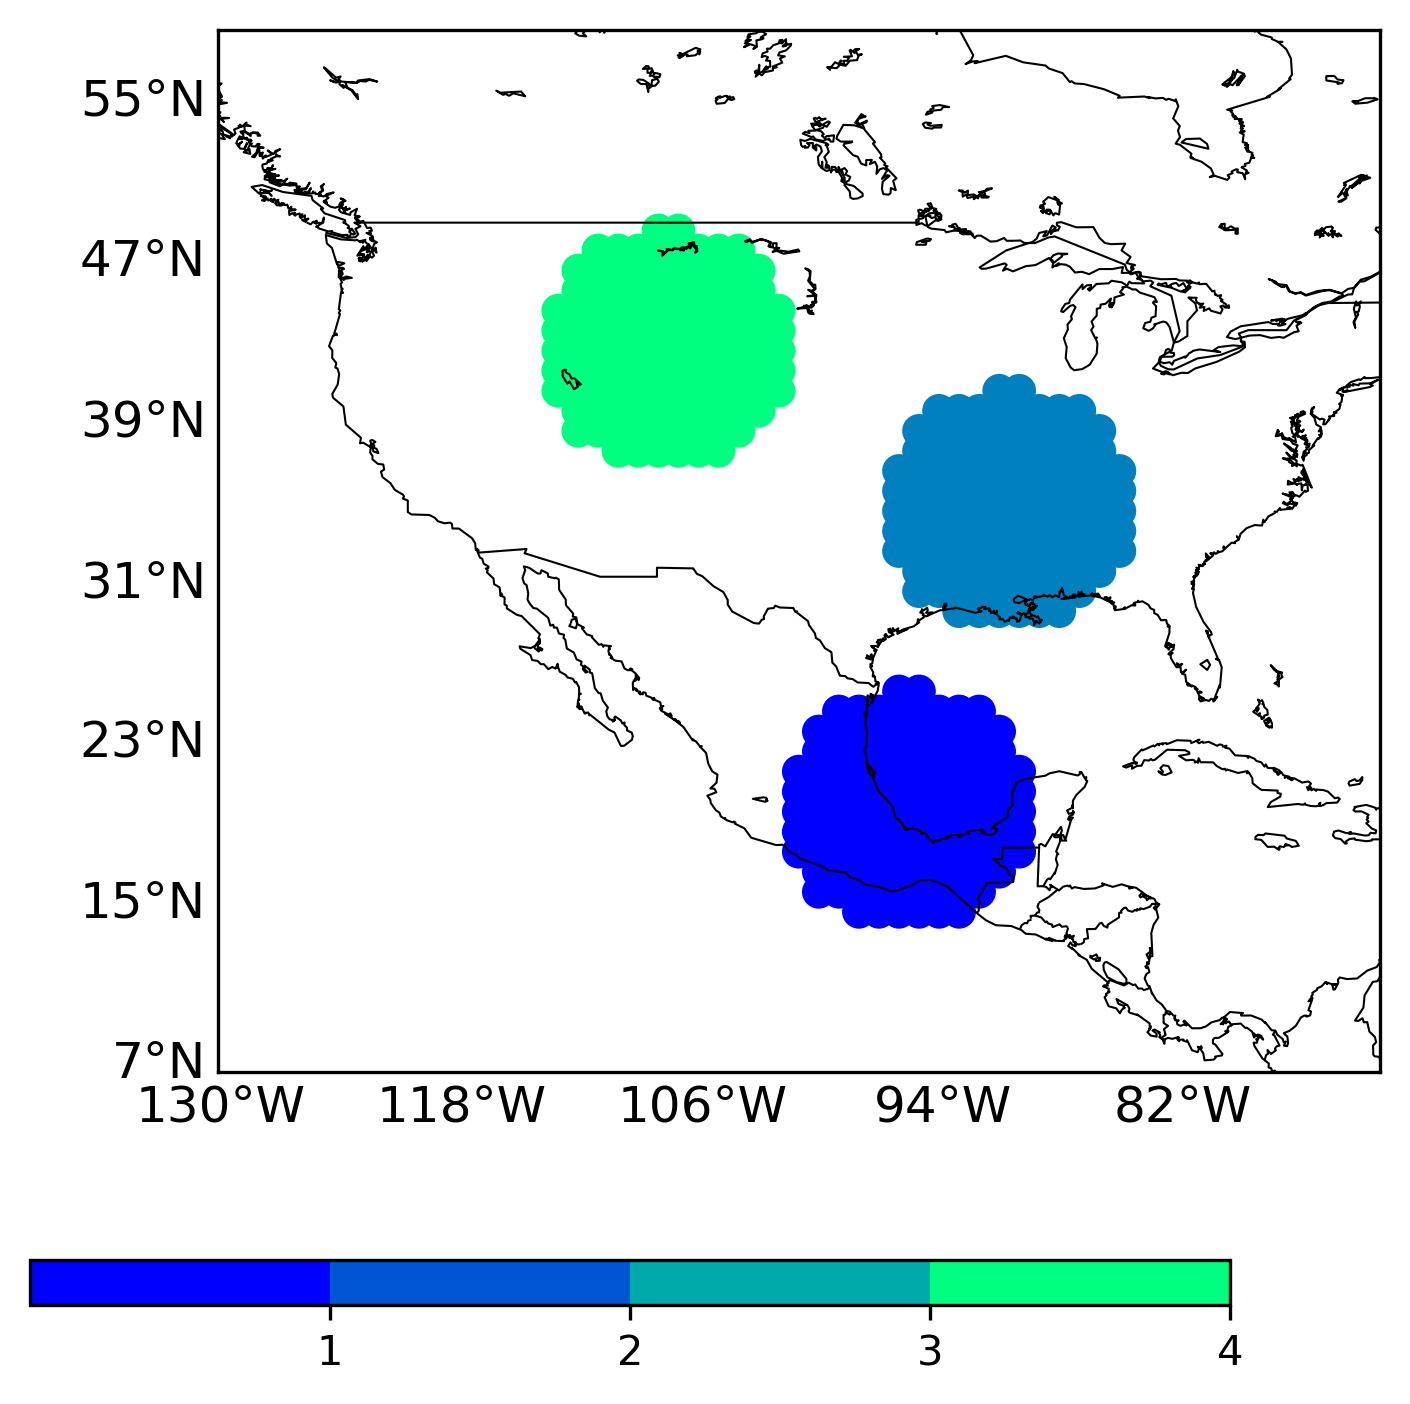

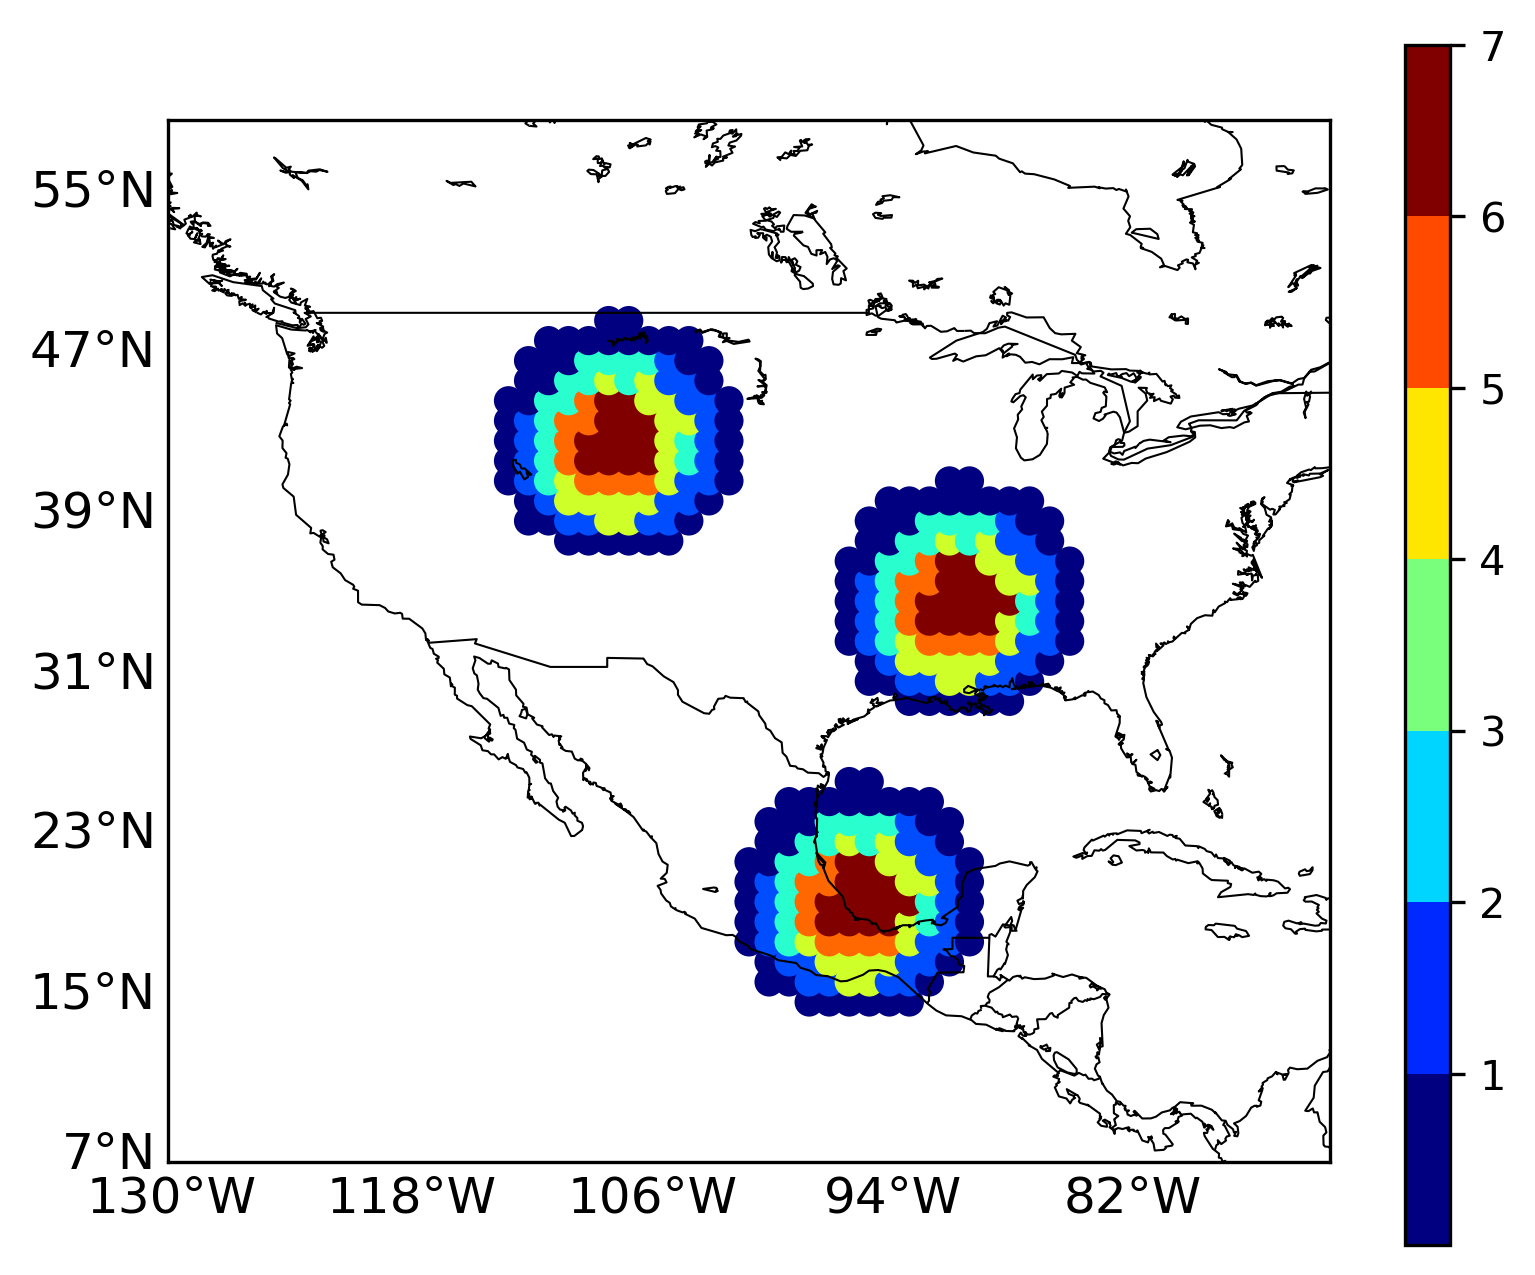

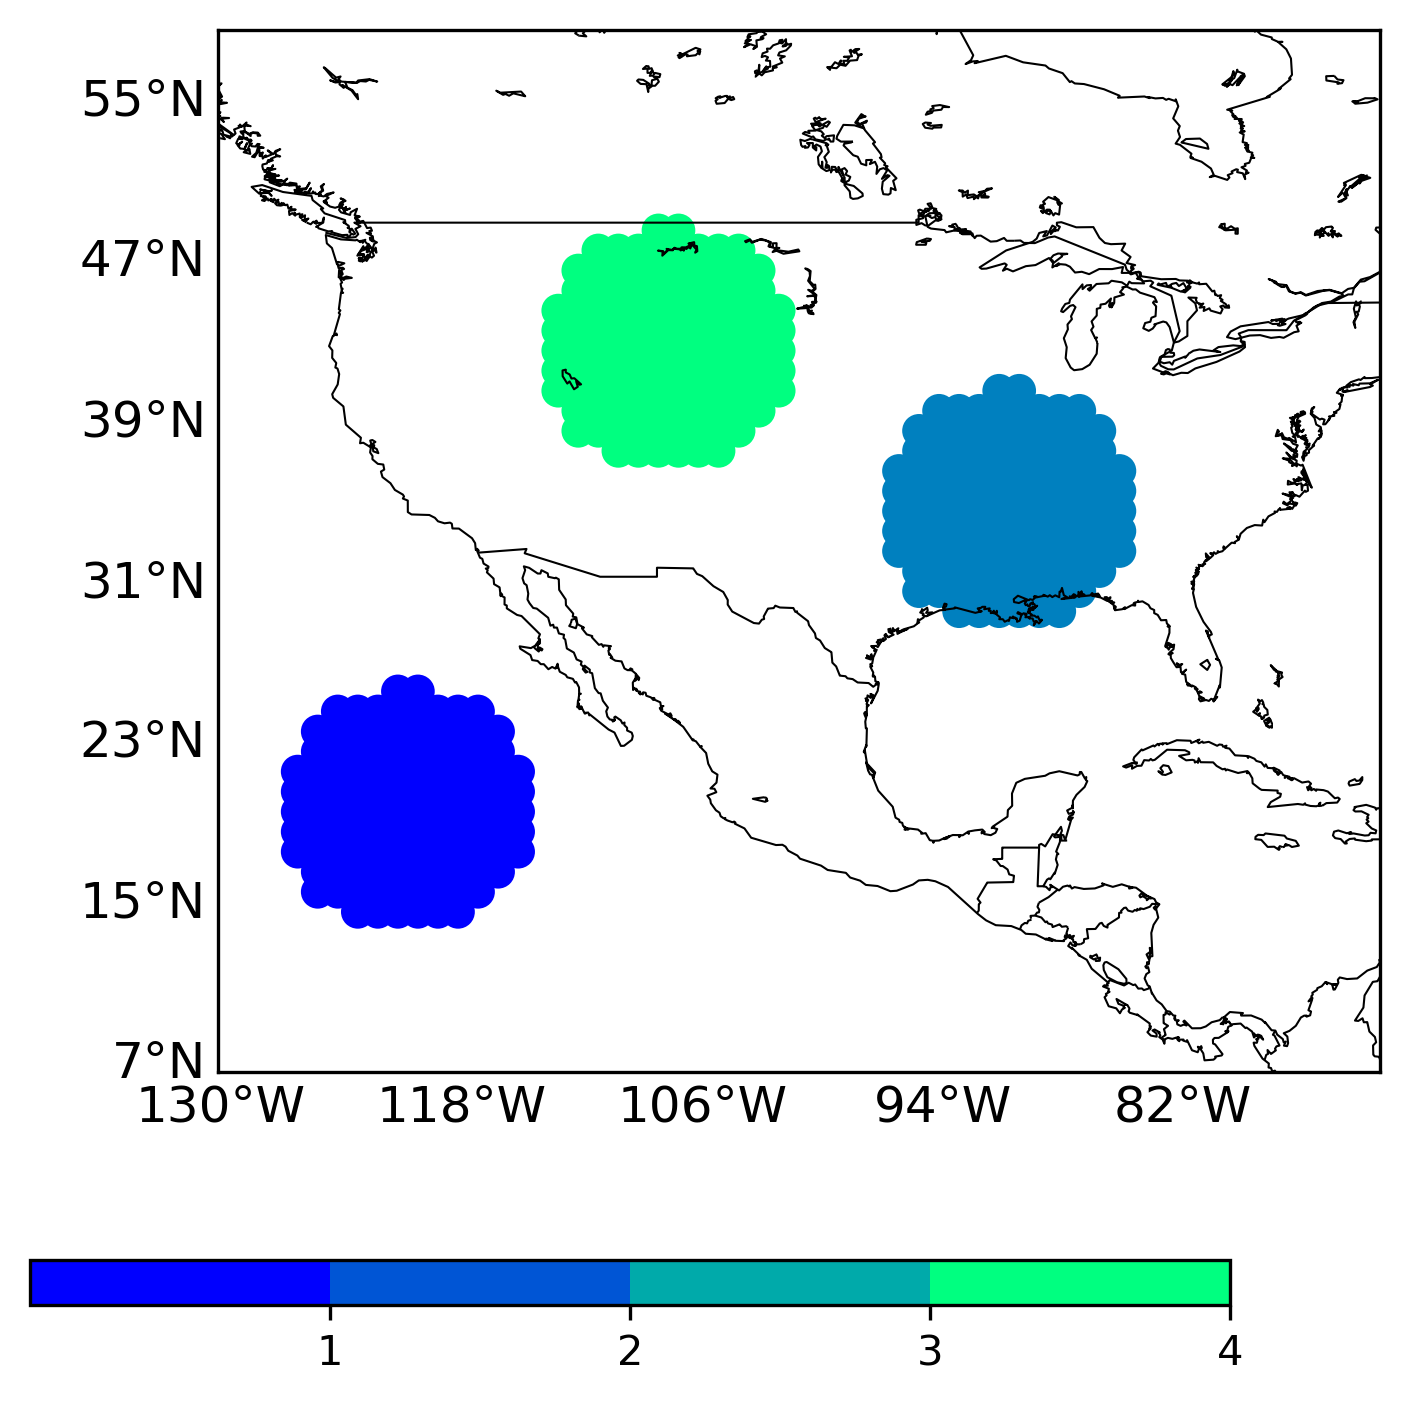

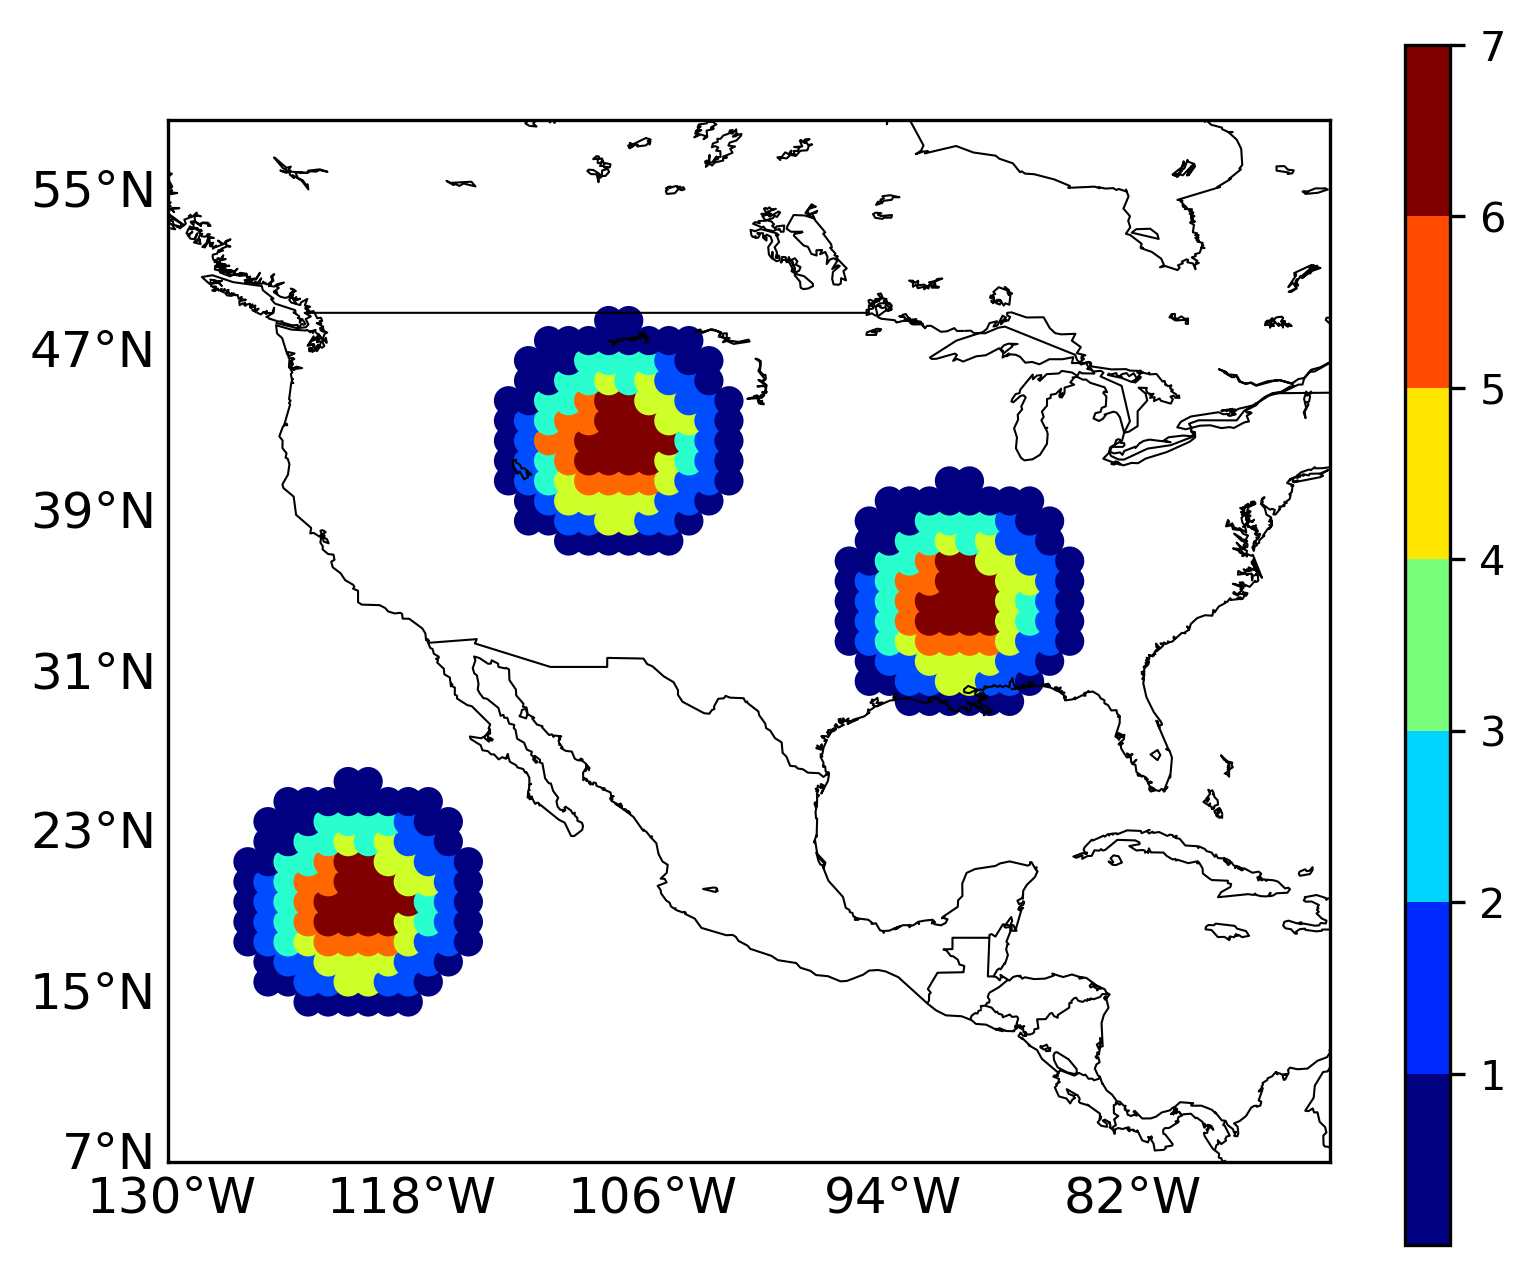

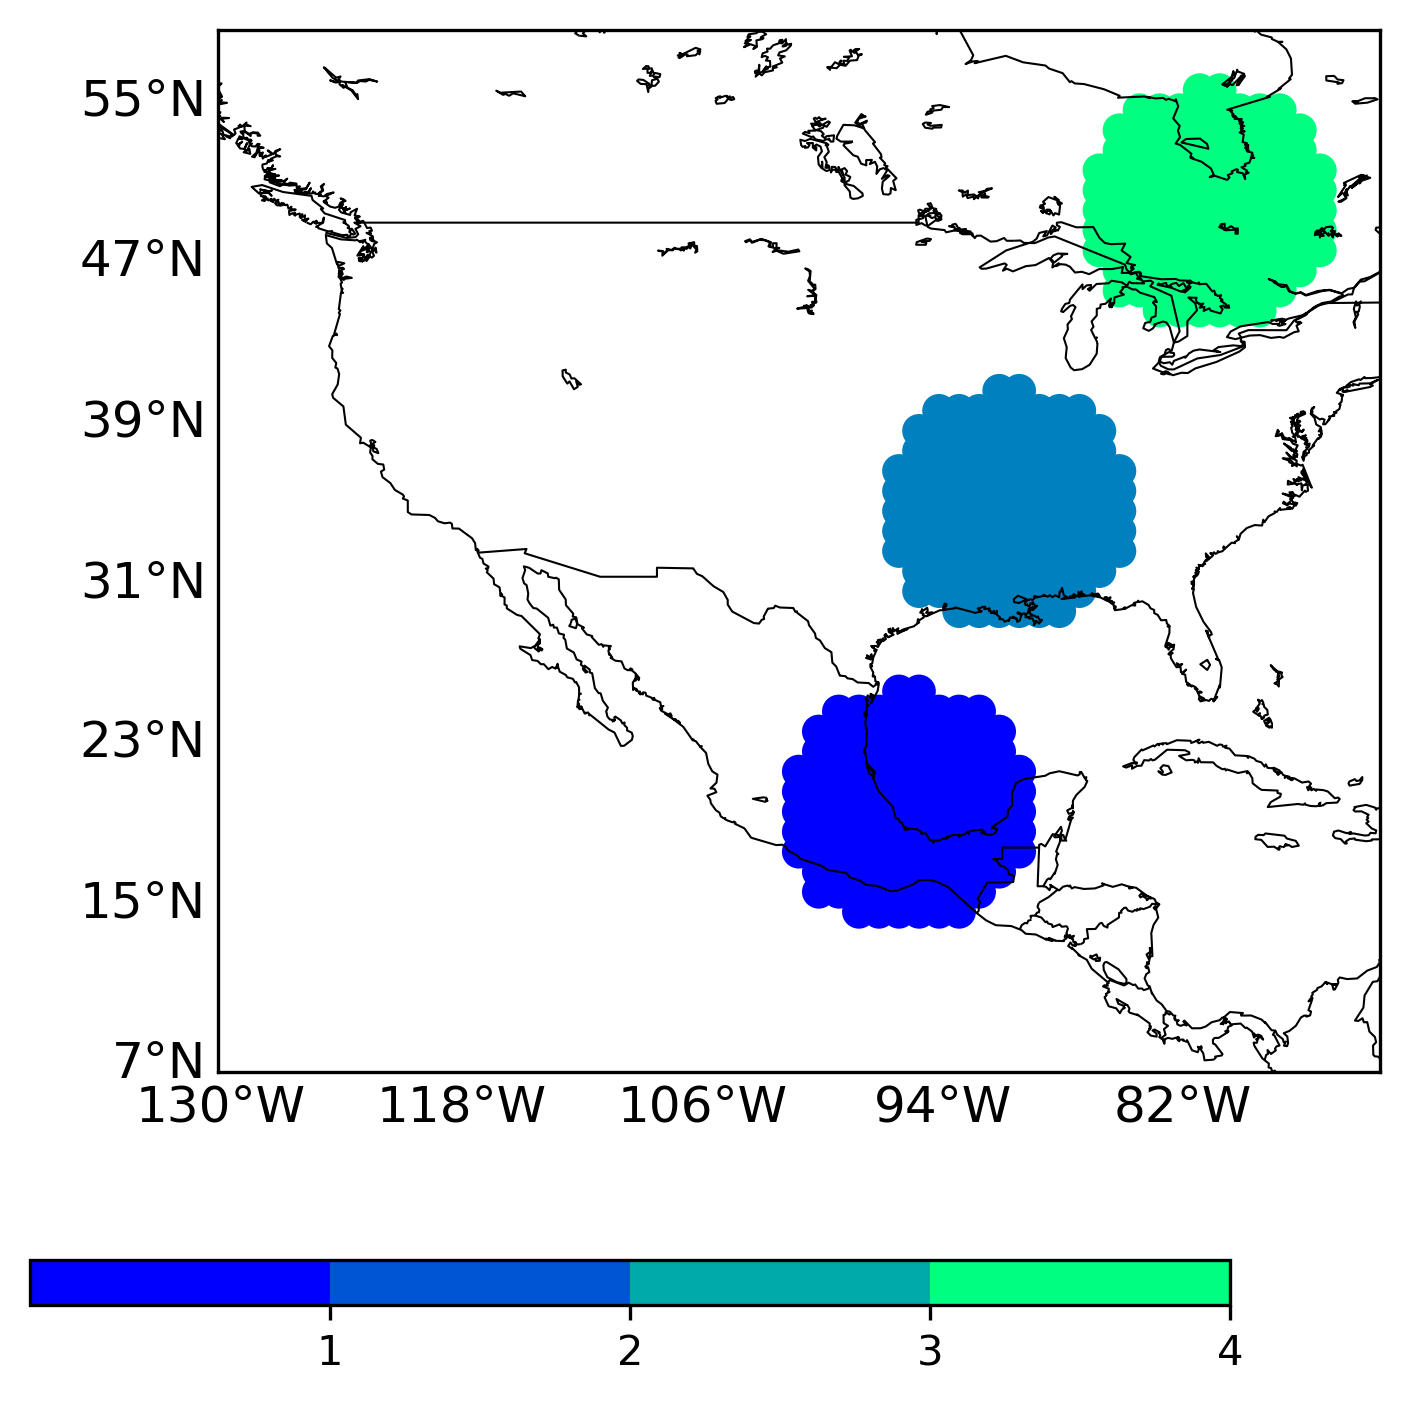

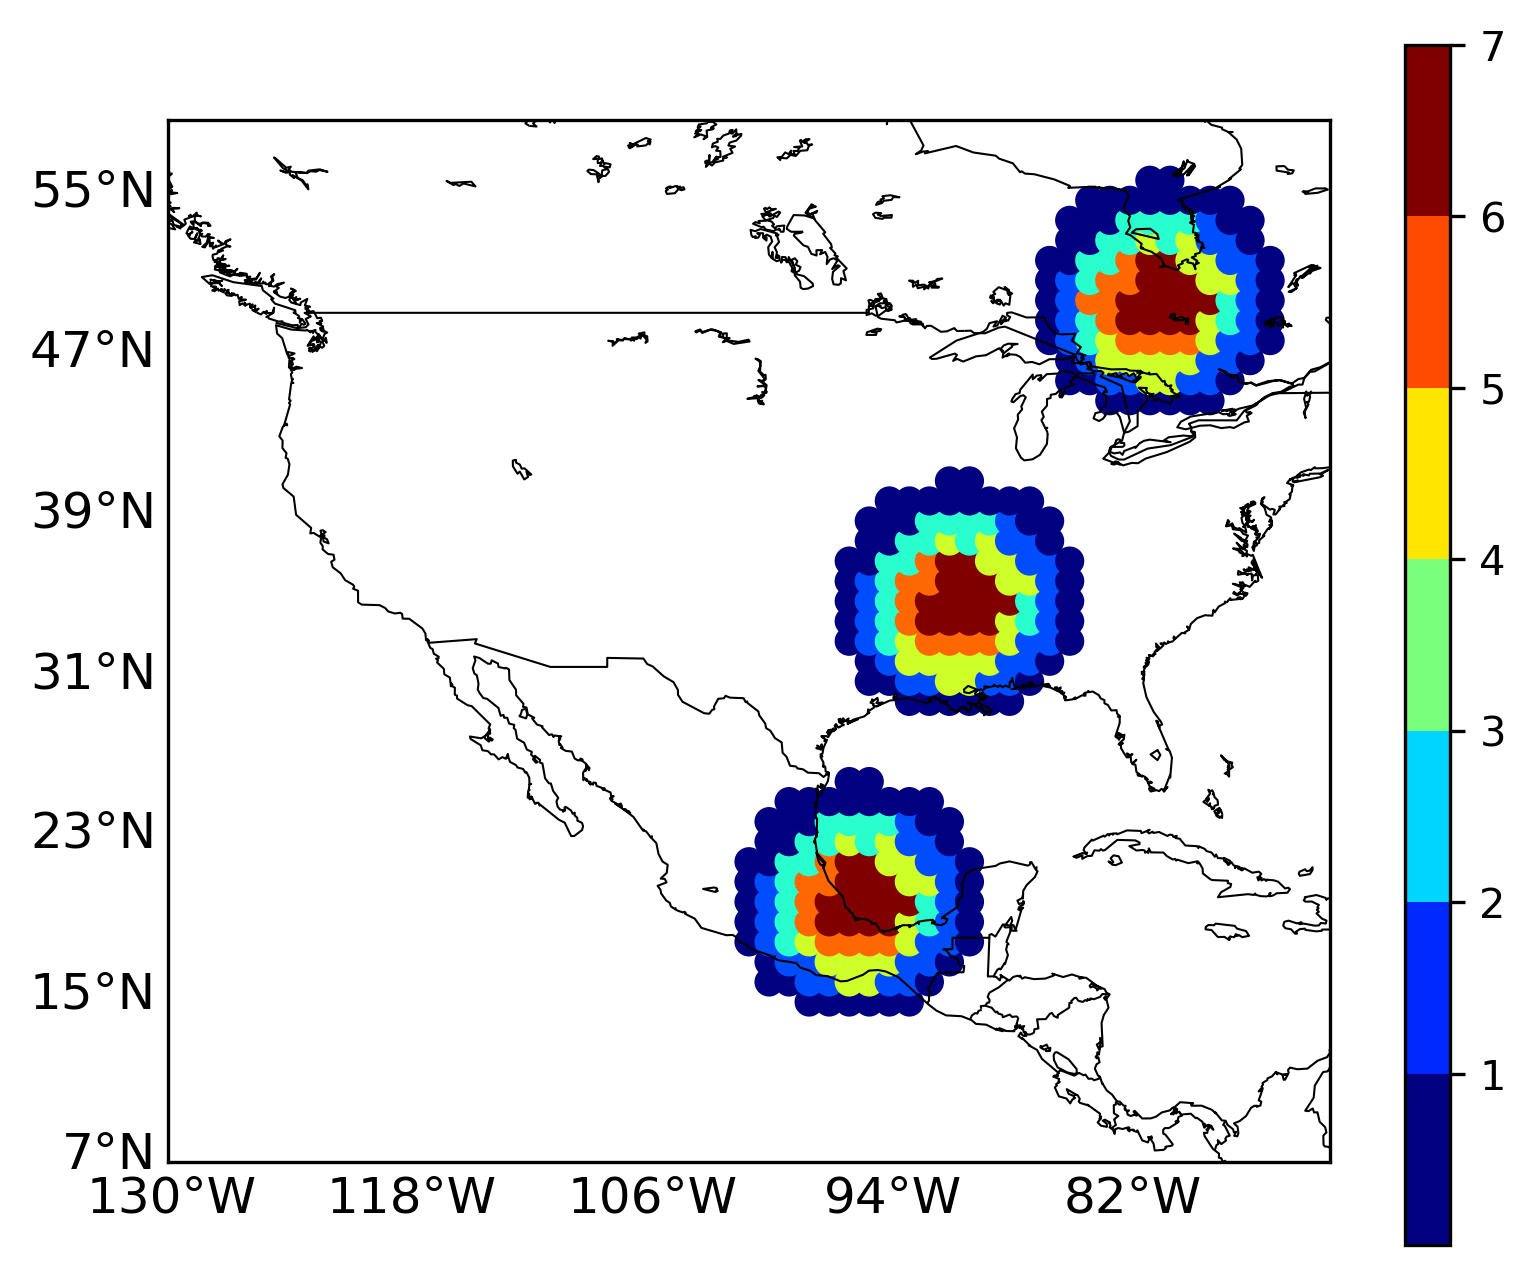

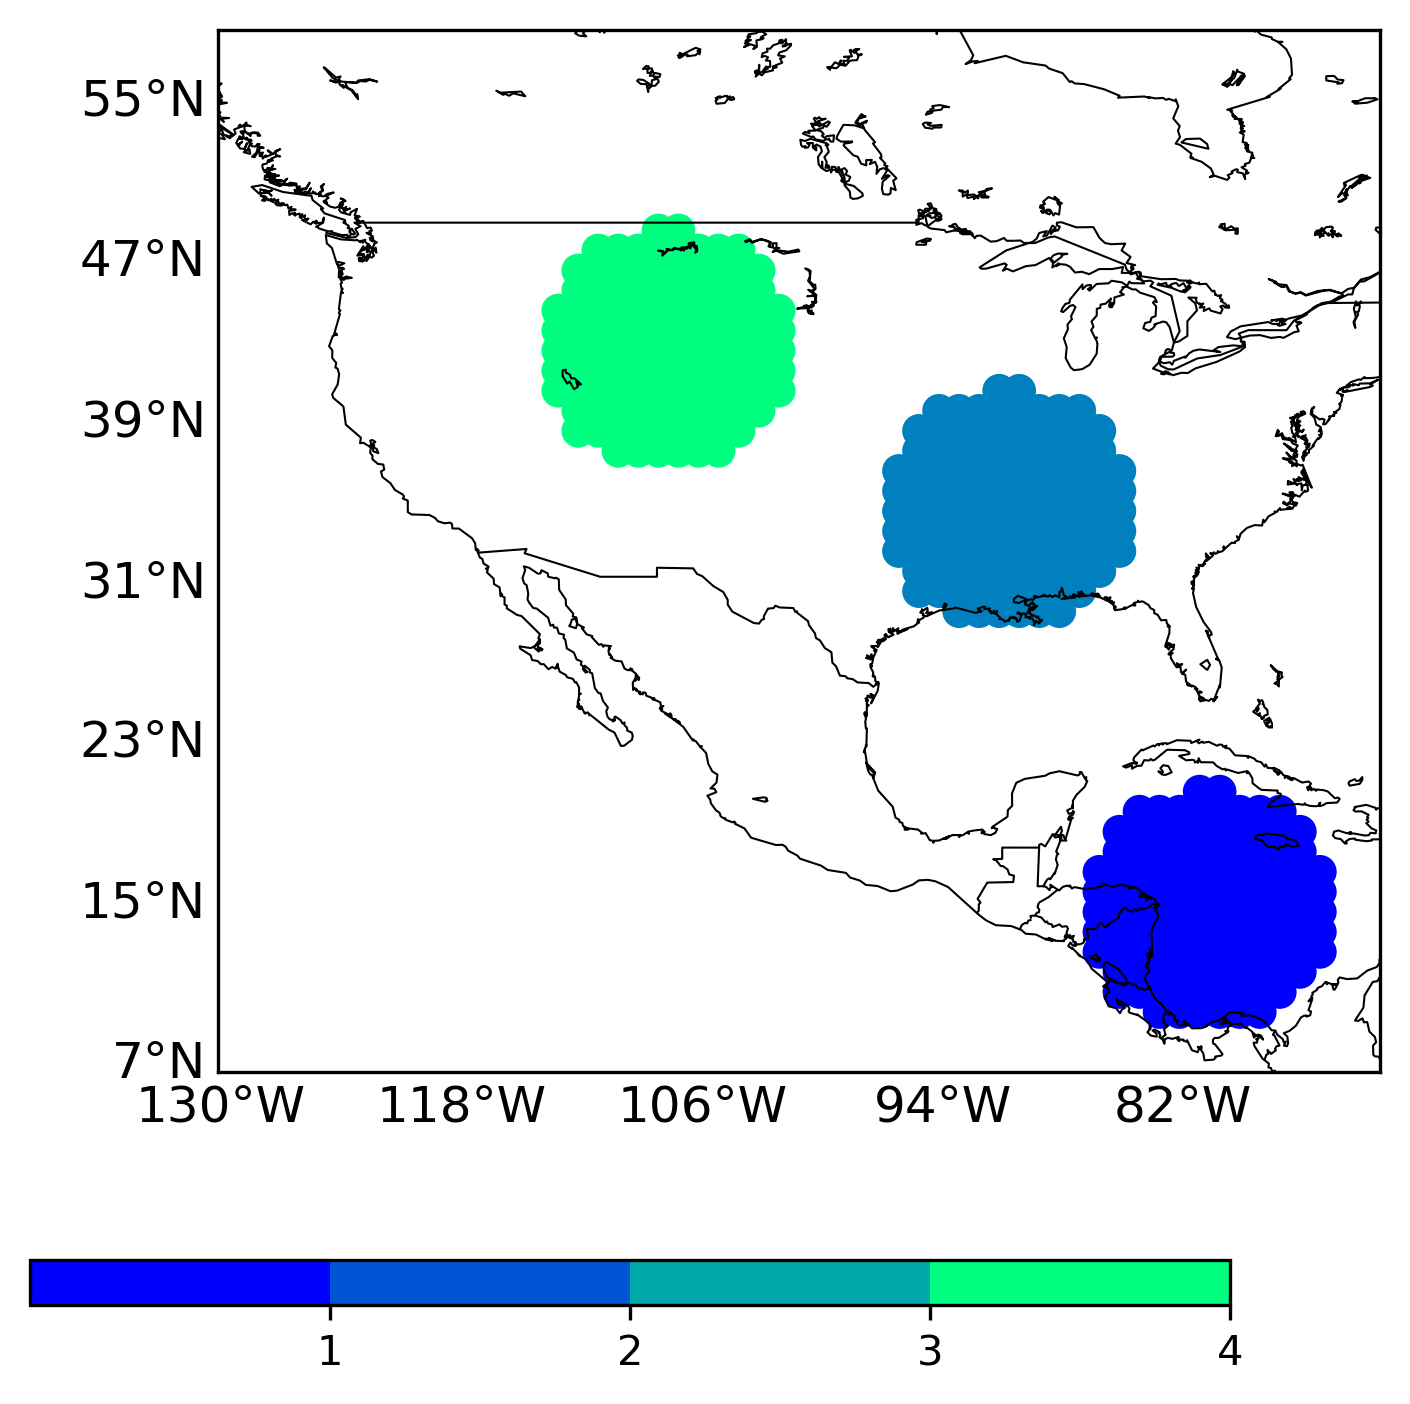

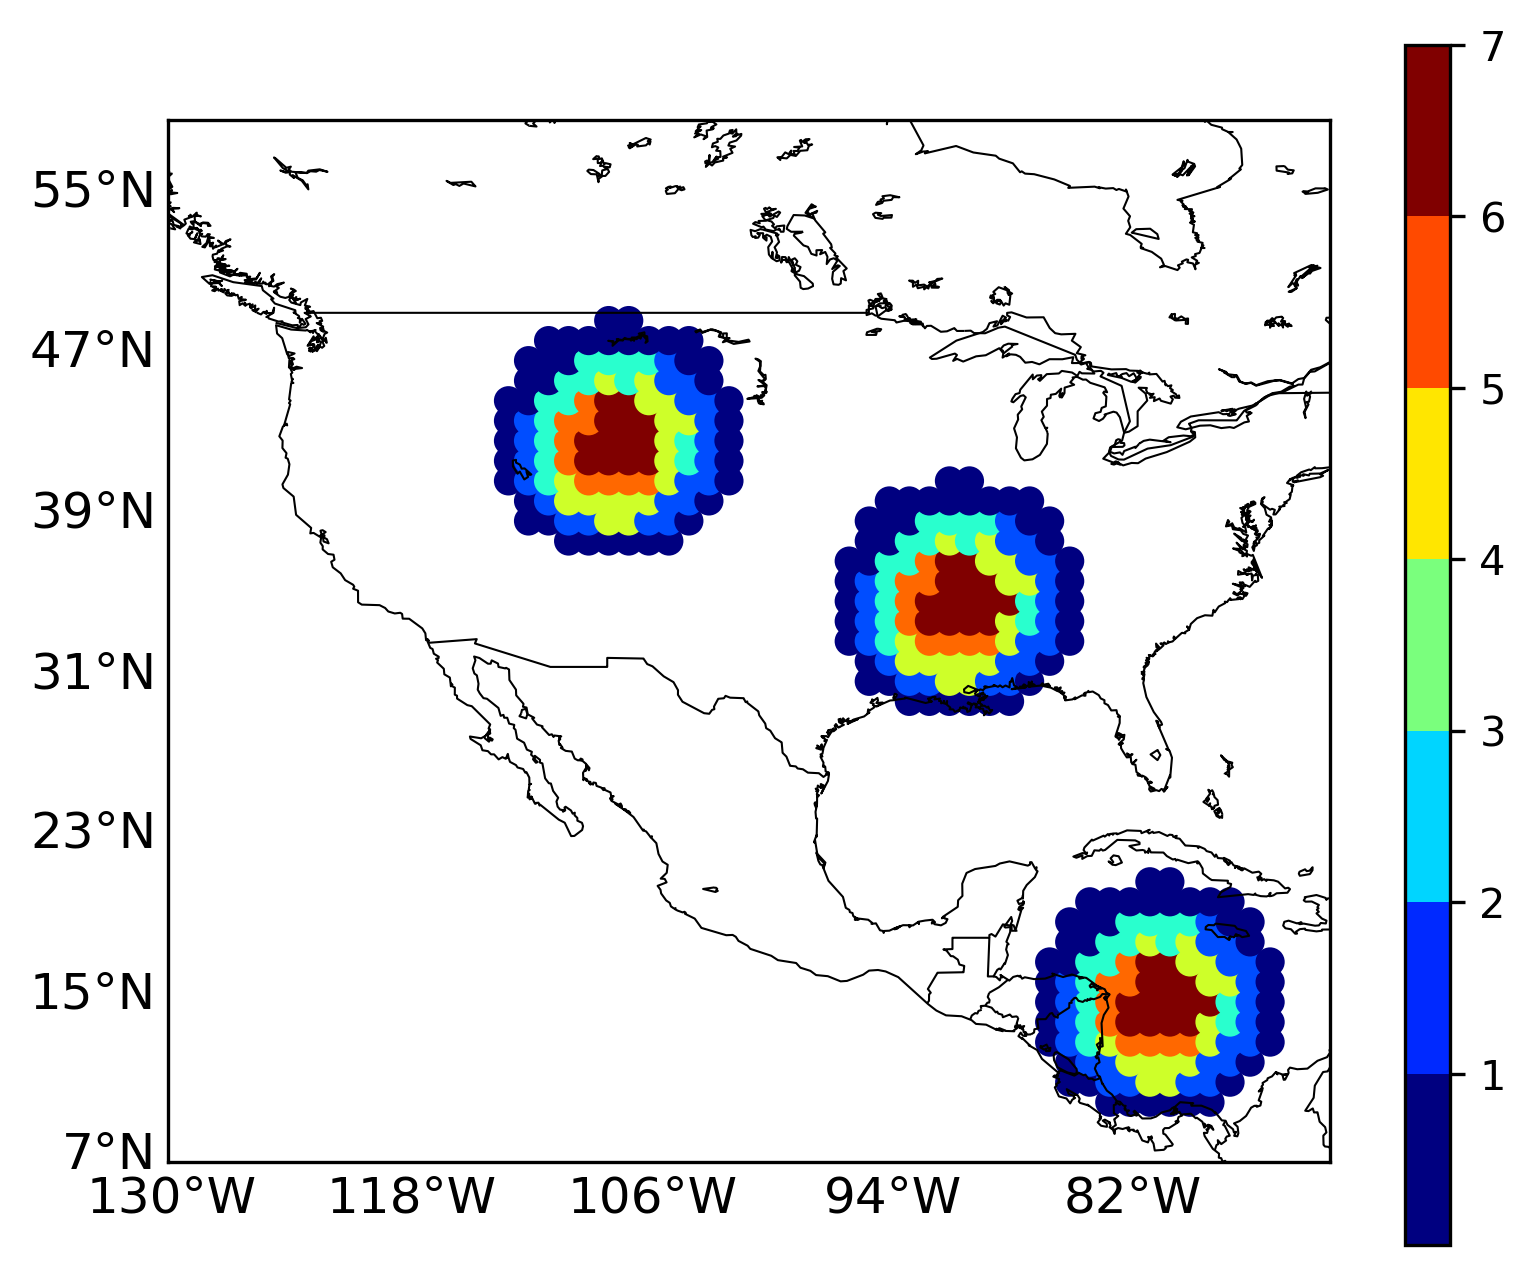

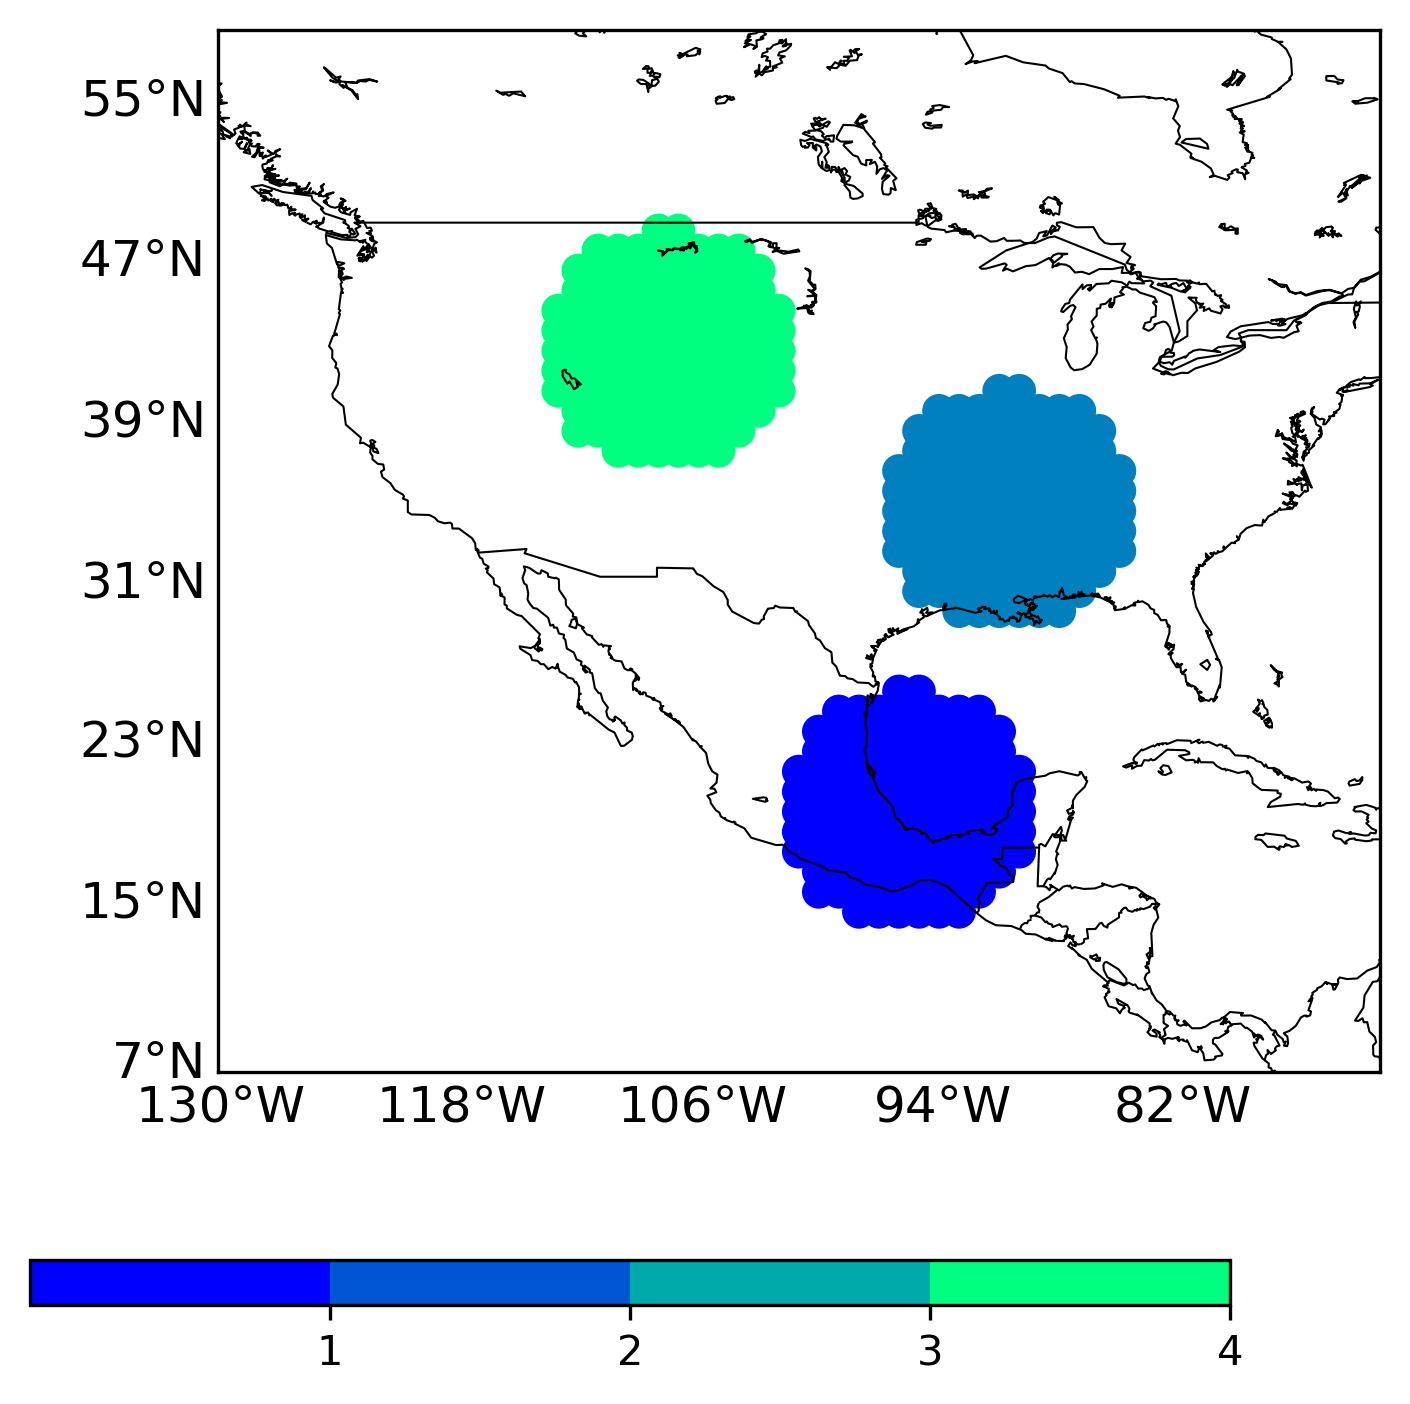

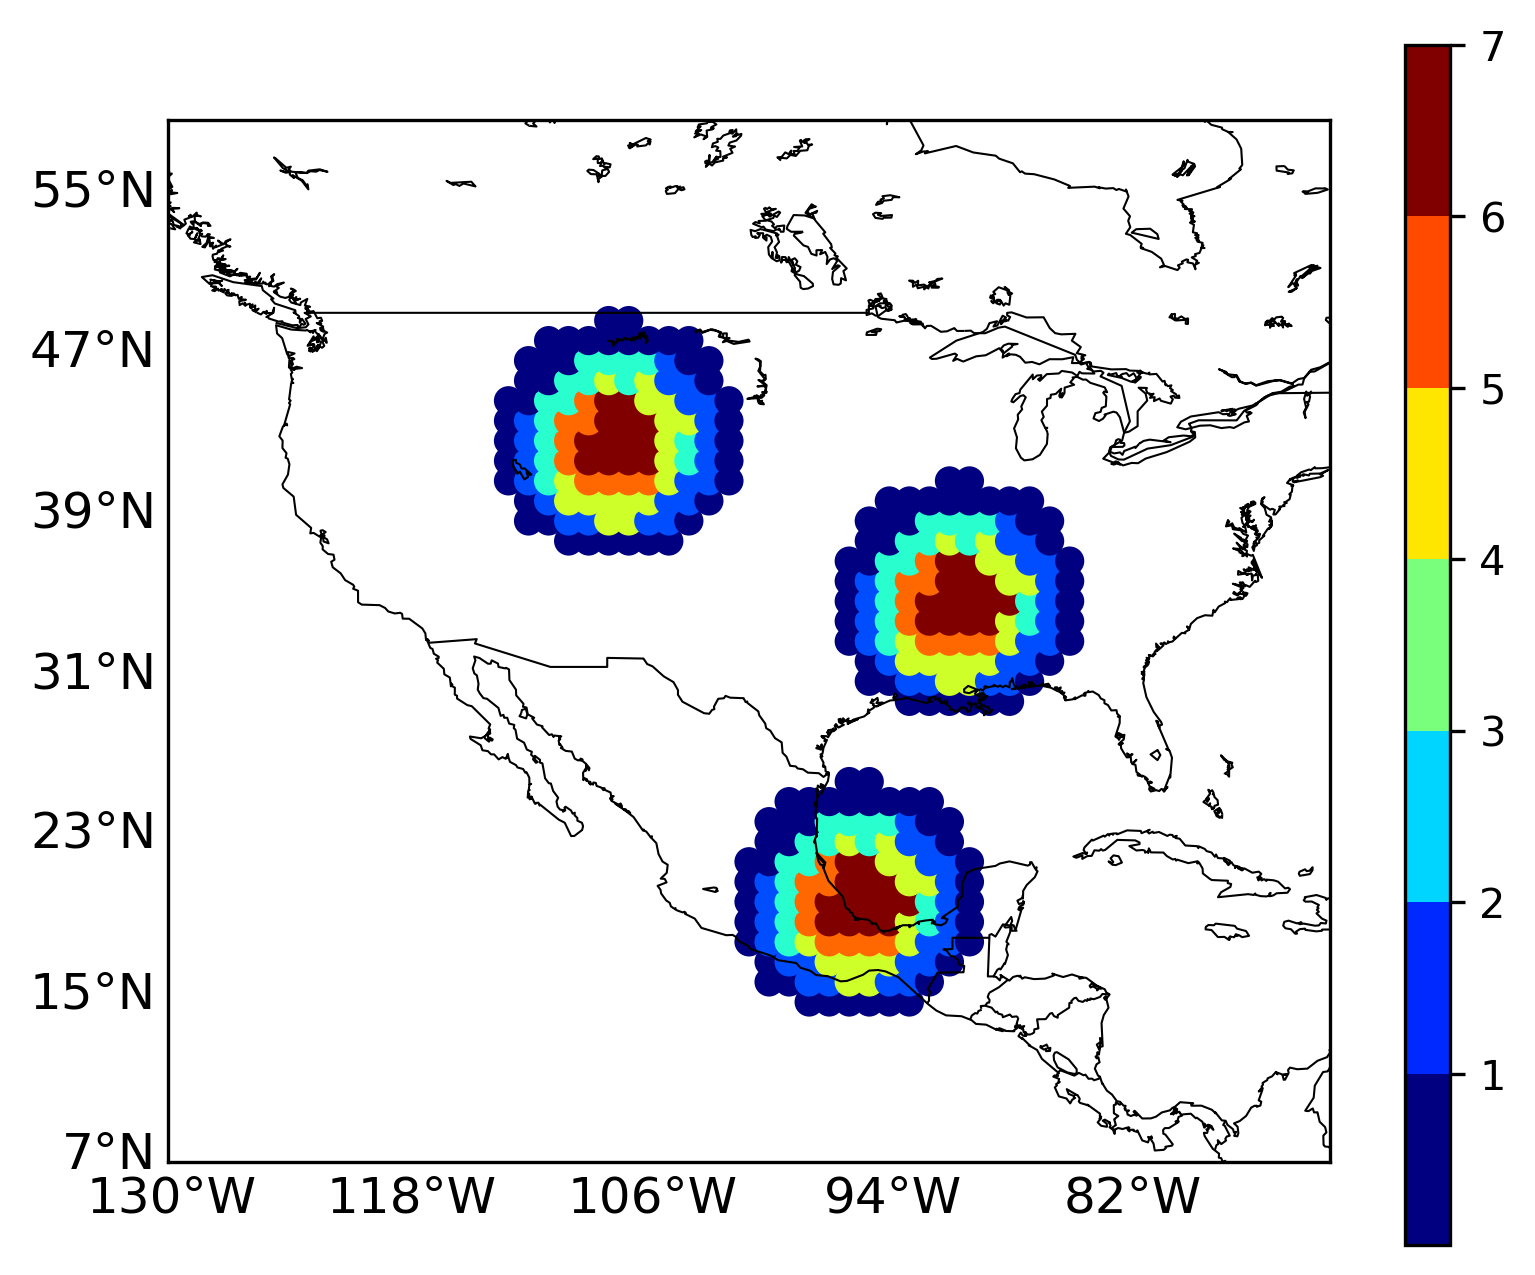

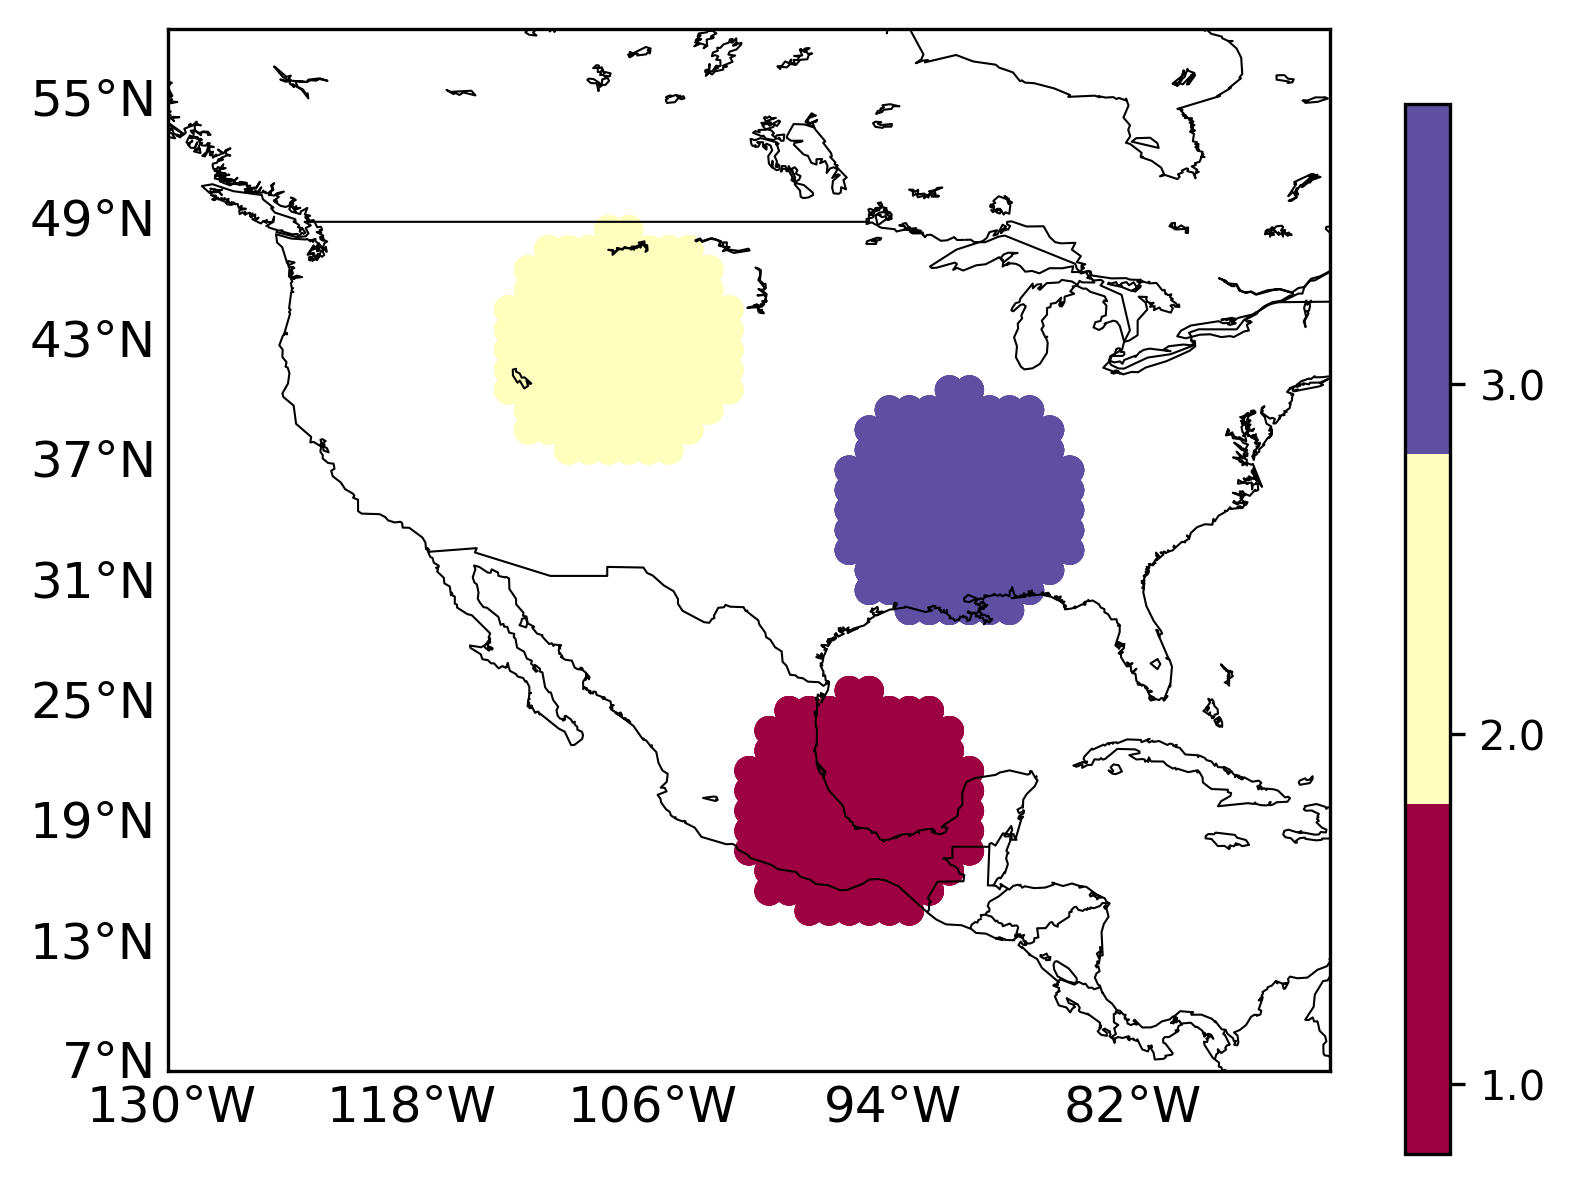

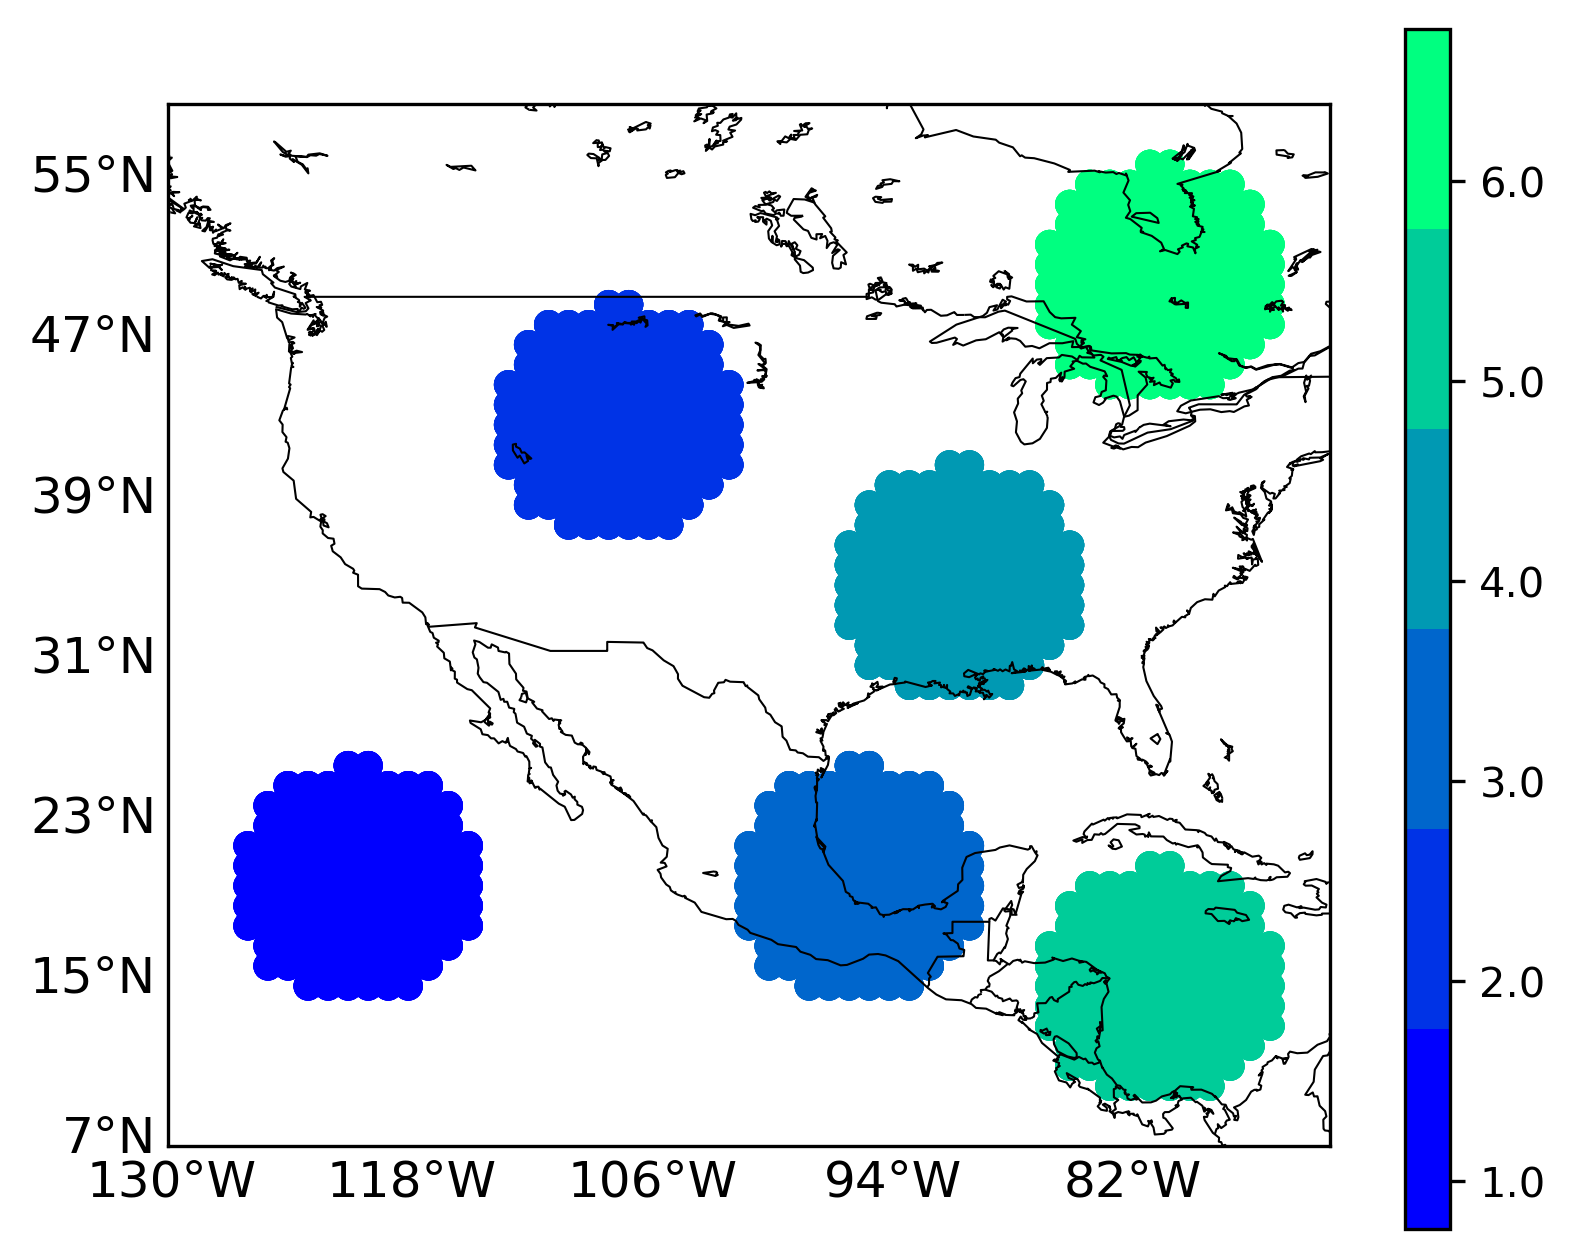

In [129]:
#Plot CLASP Outputs
if len((CLASP_output[0,:])) == 6 or len((CLASP_output[0,:])) == 9:
    Outputs_SpMg = [CLASP_output[CLASP_output[:,0]==k] for k in np.unique(CLASP_output[:,0])]
    for C in range(0,len(Outputs_SpMg)):
        CC= Outputs_SpMg[C]
        #Spatial Clusters
        cmap =  plt.get_cmap('winter')
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap.N)
    
        bounds = np.linspace(0, len(np.unique(CC[:,4])),len(np.unique(CC[:,4]))+1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        ticks = np.linspace(1, len(np.unique(CC[:,4])),len(np.unique(CC[:,4])))
    
        fig, ax  = plt.subplots(figsize=(5,5), dpi=300)
        m = Basemap(projection='cyl',resolution='l',
                llcrnrlat=LatMin,urcrnrlat=LatMax,
                llcrnrlon=LonMin,urcrnrlon=LonMax)
        m.drawcoastlines(linewidth=0.5)
        m.drawcountries()
        m.drawparallels(np.arange(round(LatMin), round(LatMax), 8), labels=[1, 0, 0, 0], linewidth=0.0,fontsize=12)
        m.drawmeridians(np.arange(round(LonMin), round(LonMax),12), labels=[0, 0, 0, 1], linewidth=0.0,fontsize=12)
        #Plot Data
        s = plt.scatter(CC[:,1], CC[:,2], c=CC[:,4], cmap=cmap, s=50) #Or 2,1 instead of 10,9 #c=[col]
        #Colorbar
        #ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8]) #Colorbar vertical
        ax2 = fig.add_axes([0, 0, 0.8, 0.03]) #Colorbar horizontal
        #[left, bottom, width, height]
        mpl.colorbar.ColorbarBase(ax2,cmap=cmap, norm=norm, orientation="horizontal", spacing='proportional',boundaries = bounds, ticks = ticks, format='%1i') #spacing='proportional', 
        #Plot Source Points
        #m.scatter(SourcePoint_LonLat[:,0],SourcePoint_LonLat[:,1],c='black', marker="*",s=50)
        plt.show()
        
        #Magnitude Clusters
        cmap = plt.get_cmap('jet') 
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap.N)
    
        bounds = np.linspace(0, len(np.unique(CC[:,5])),len(np.unique(CC[:,5]))+1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        ticks = np.linspace(1, len(np.unique(CC[:,5])),len(np.unique(CC[:,5])))
    
        fig, ax  = plt.subplots(figsize=(5,5), dpi=300)
        m = Basemap(projection='cyl',resolution='l',
            llcrnrlat=LatMin,urcrnrlat=LatMax,
            llcrnrlon=LonMin,urcrnrlon=LonMax)
        m.drawcoastlines(linewidth=0.5)
        m.drawcountries()
        m.drawparallels(np.arange(round(LatMin), round(LatMax), 8), labels=[1, 0, 0, 0], linewidth=0.0,fontsize=12)
        m.drawmeridians(np.arange(round(LonMin), round(LonMax),12), labels=[0, 0, 0, 1], linewidth=0.0,fontsize=12)
        #Plot Data
        s = plt.scatter(CC[:,1], CC[:,2], c=CC[:,5], cmap=cmap, ) #Or s=50 2,1 instead of 10,9 #c=[col]
        #Colorbar
        ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional',boundaries = bounds, ticks = ticks, format='%1i') #spacing='proportional', 
        #Plot Source Points
        #m.scatter(SourcePoint_LonLat[:,0],SourcePoint_LonLat[:,1],c='black', marker="*",s=50)
        plt.show()

#Plot Temporal Clusters
if len((CLASP_output[0,:])) == 9:
    #Temporal Cluster Plot
    bounds = np.linspace(0, np.count_nonzero(~np.isnan(np.unique(CLASP_output[:,7]))), np.count_nonzero(~np.isnan(np.unique(CLASP_output[:,7])))+1) 
    vals = bounds[:-1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap1.N)
    ticks = np.linspace(1, np.count_nonzero(~np.isnan(np.unique(CLASP_output[:,7]))),np.count_nonzero(~np.isnan(np.unique(CLASP_output[:,7]))))
    
    fig, ax  = plt.subplots(figsize=(5,5), dpi=300)
    m = Basemap(projection='cyl',resolution='l',
            llcrnrlat=LatMin,urcrnrlat=LatMax,
            llcrnrlon=LonMin,urcrnrlon=LonMax)
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries()
    m.drawparallels(np.arange(round(LatMin), round(LatMax), 6), labels=[1, 0, 0, 0], linewidth=0.0, fontsize=12)
    m.drawmeridians(np.arange(round(LonMin), round(LonMax),12), labels=[0, 0, 0, 1], linewidth=0.0, fontsize=12)
    #Temporal Clusters
    m.scatter(CLASP_output[:,1], CLASP_output[:,2], c=CLASP_output[:,7],cmap=cmap1) 
    #Source Points
    #m.scatter(SourcePoint_LonLat[:,0],SourcePoint_LonLat[:,1],c='black', marker="*",s=50)
    #Colorbar
    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.7])
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap1, norm=norm, boundaries = bounds, values=vals, format='%1i') #spacing='proportional', 
    cbar.set_ticks(vals + .2)
    cbar.set_ticklabels(ticks)
    plt.show()
    
    #Spatial Locations of the temporal clusters
    # create the new map
    cmap1 = plt.get_cmap('winter')
    cmaplist1 = [cmap1(i) for i in range(cmap1.N)]
    cmap1 = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist1, cmap1.N)
    
    #Bounds are based on the number of unique dates
    bounds = np.linspace(np.nanmin(np.unique(CLASP_output[:,8])), np.nanmax(np.unique(CLASP_output[:,8])),len(np.unique(CLASP_output[:,8]))) 
    vals = bounds[:-1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap1.N)
    ticks = np.linspace(1, np.nanmax(np.unique(CLASP_output[:,8]))+1,len(np.unique(CLASP_output[:,8]))-1) 
    
    fig, ax  = plt.subplots(figsize=(5,5), dpi=300)
    m = Basemap(projection='cyl',resolution='l',
            llcrnrlat=LatMin,urcrnrlat=LatMax,
            llcrnrlon=LonMin,urcrnrlon=LonMax)
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries()
    m.drawparallels(np.arange(round(LatMin), round(LatMax), 8), labels=[1, 0, 0, 0], linewidth=0.0,fontsize=12)
    m.drawmeridians(np.arange(round(LonMin), round(LonMax),12), labels=[0, 0, 0, 1], linewidth=0.0,fontsize=12)
    #Plot Data
    s = plt.scatter(CLASP_output[:,1], CLASP_output[:,2], c=CLASP_output[:,8], cmap=cmap1 ) 
    #Colorbar
    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap1, norm=norm, spacing='proportional',boundaries = bounds, values=vals, format='%1i') #spacing='proportional', 
    cbar.set_ticks(vals + .2)
    cbar.set_ticklabels(ticks)
    plt.show()